# Explainable AI Notebook

## Imports

In [1]:
# Set root directory of the project as the current working directory
import os
import sys

module_path = os.path.abspath('..')
if module_path not in sys.path:
    %cd ..




/Users/johannesherstad/Master_Herstad-Gjerdingen


In [2]:
# ======================
# Standard Library
# ======================
import logging
import os
import random

# ======================
# Third-Party Libraries
# ======================
import kerastuner as kt
import lime
from lime.lime_tabular import LimeTabularExplainer
import mat4py as mpy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import shap
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

# ======================
# TensorFlow / Keras
# ======================
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# ======================
# Custom Modules
# ======================
from config.defaults import Config
from src.evaluation import evaluate_regression_model, plot_true_vs_pred
from src.models import load_preprocessed_data, load_saved_model

# ======================
# Configuration
# ======================
logging.getLogger().setLevel(logging.WARNING)
config = Config()



# To be sorted:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import plotly.express as px
from ipywidgets import interact, IntSlider


/var/folders/nn/4_r89tj92wd44cypgj5z6vkh0000gn/T/ipykernel_55311/1985296423.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


## Data loading

In [3]:
# Load preprocessed data

# Regression
X_train, X_val, X_test, y_train_reg, y_val_reg, y_test_reg, metadata = load_preprocessed_data(model_task = "regression" ,dataset="MIT_Stanford",eol_capacity=config.eol_capacity)

# Classification
X_train, X_val, X_test, y_train_clf, y_val_clf, y_test_clf, metadata = load_preprocessed_data(model_task = "classification",dataset="MIT_Stanford", eol_capacity=config.eol_capacity)

classification_labels = config.labels


In [4]:
metadata

{'y_max': 1928.0,
 'seq_len': 120,
 'eol_capacity': 0.8,
 'classification': True,
 'timestamp': '20250321_135350'}

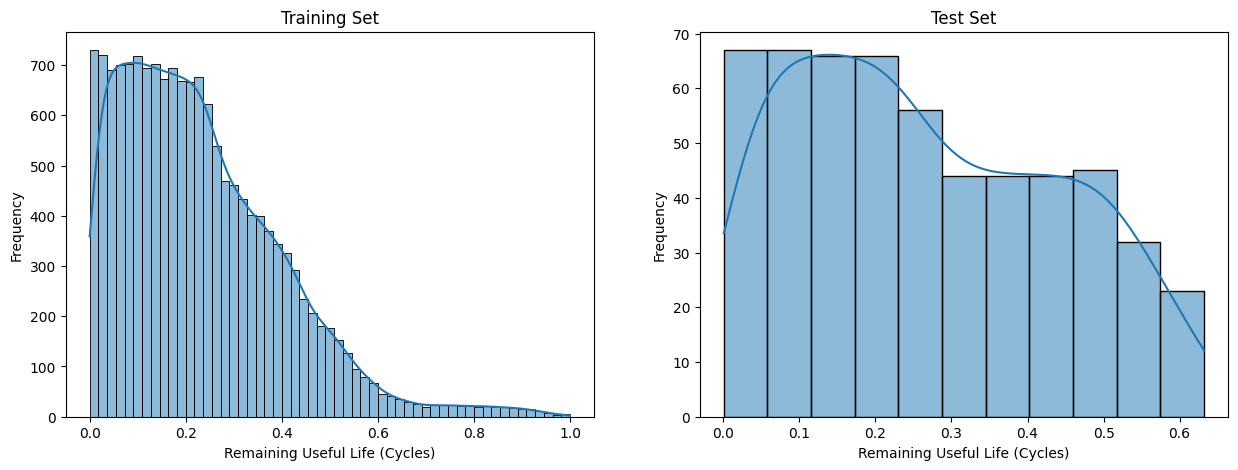

In [5]:
# Plot the distribution of the target variable
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(y_train_reg, ax=ax[0], kde=True)
ax[0].set_title("Training Set")
ax[0].set_xlabel("Remaining Useful Life (Cycles)")
ax[0].set_ylabel("Frequency")

sns.histplot(y_test_reg, ax=ax[1], kde=True)
ax[1].set_title("Test Set")
ax[1].set_xlabel("Remaining Useful Life (Cycles)")
ax[1].set_ylabel("Frequency")

plt.show()


/var/folders/nn/4_r89tj92wd44cypgj5z6vkh0000gn/T/ipykernel_55311/3799203689.py:17: RuntimeWarning: Mean of empty slice.
  avg_time_series = X_test[mask].mean(axis=0).squeeze()
/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


IndexError: list index out of range

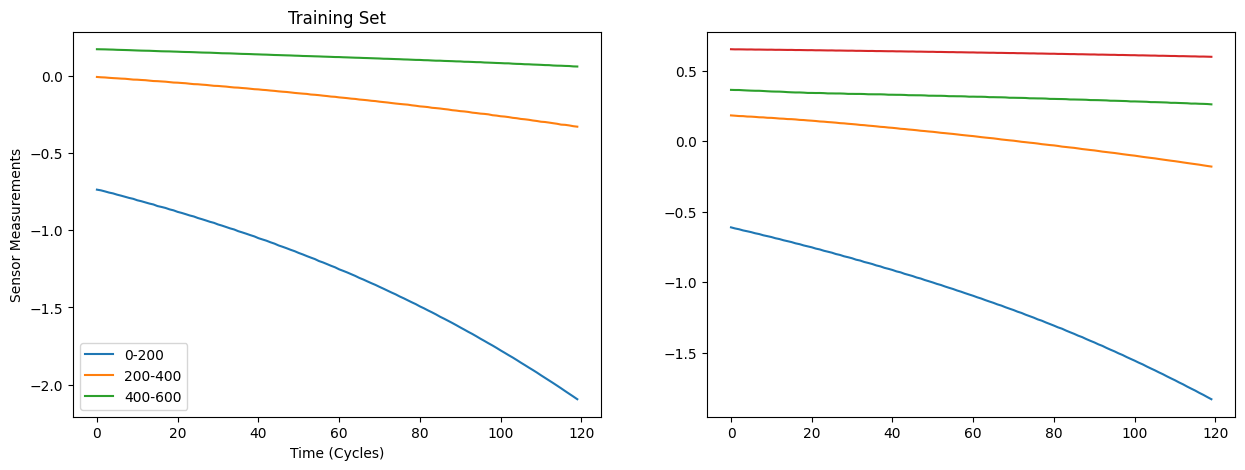

In [6]:
# Plot the average time series for each class
# There are 7 classification_labels  = ["0-200", "200-300", "300-400", "400-500", "500-600", "600-700", "700+"]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i in range(config.n_bins-1):
    mask = np.argmax(y_train_clf, axis=1) == i
    avg_time_series = X_train[mask].mean(axis=0).squeeze()
    ax[0].plot(avg_time_series, label=classification_labels[i])

ax[0].set_title("Training Set")
ax[0].set_xlabel("Time (Cycles)")
ax[0].set_ylabel("Sensor Measurements")
ax[0].legend()

for i in range(7):
    mask = np.argmax(y_test_clf, axis=1) == i
    avg_time_series = X_test[mask].mean(axis=0).squeeze()
    ax[1].plot(avg_time_series, label=classification_labels[i])

ax[1].set_title("Test Set")
ax[1].set_xlabel("Time (Cycles)")
ax[1].set_ylabel("Sensor Measurements")
ax[1].legend()

plt.show()




In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

# Assuming X_train is your training set array.
# For instance, X_train might have shape (n_samples, 120, 1).

# Randomly select 50 samples from the training set
n_samples_total = X_train.shape[0]
selected_indices = np.random.choice(n_samples_total, size=50, replace=False)
X_random = X_train[selected_indices]

# If X_random has shape (50, 120, 1), squeeze the last dimension
if len(X_random.shape) == 3:
    n_samples, n_timesteps, n_features = X_random.shape
    if n_features == 1:
        X_random = X_random.squeeze(axis=-1)  # now shape is (n_samples, n_timesteps)
    else:
        raise ValueError("Expected feature dimension to be 1 for plotting a single time series per sample.")
else:
    n_samples, n_timesteps = X_random.shape

# Create a DataFrame where each row is a sample and each column is a timestep
df = pd.DataFrame(X_random, columns=[f"timestep_{i}" for i in range(n_timesteps)])
df["sample"] = selected_indices  # Label the samples with their original indices

# Melt the DataFrame to long format: each row becomes (sample, timestep, value)
df_long = df.melt(id_vars="sample", var_name="timestep", value_name="value")
# Convert the 'timestep' column from "timestep_0" to an integer (0)
df_long["timestep"] = df_long["timestep"].str.replace("timestep_", "").astype(int)

# Create a line plot with Plotly Express: one line per sample
fig = px.line(
    df_long,
    x="timestep",
    y="value",
    color="sample",
    title="Time Series of 50 Random Training Samples",
    labels={"timestep": "Timestep", "value": "Capacity Value", "sample": "Sample Index"}
)

fig.show()


## Load and Evaluate models

### Regression

#### LSTM

In [8]:
y_test_reg.max()*metadata["y_max"]

1219.0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - mae: 0.0890  


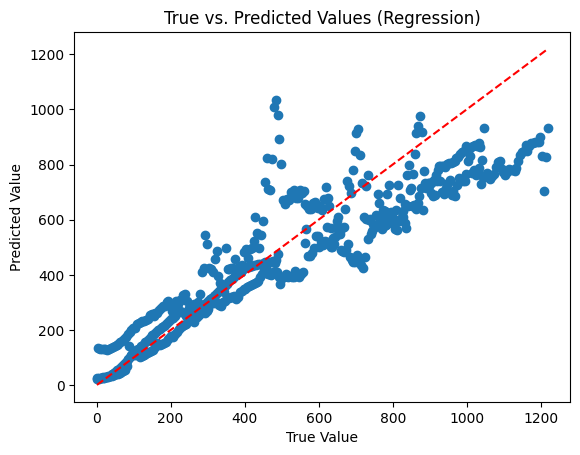

Test MSE: 0.00594568211744945
Test R2: 0.7993803183885071
Test MAE: 0.05731304289140376


In [9]:
# 1) Load the model
lstm_model = load_saved_model(model_task = "lstm_regression", config=config)



# 2) Generate predictions
y_pred = lstm_model.predict(X_test)

# 3) Evaluate (for example, if your evaluate_regression_model only needs X_test, y_test)
test_loss, mae_rescaled = evaluate_regression_model(
    model=lstm_model, 
    X_test=X_test, 
    y_test=y_test_reg, 
    y_max=metadata["y_max"]
)

# 4) Plot
plot_true_vs_pred(y_test_reg, y_pred, y_max=metadata["y_max"])

mse_test_lstm = mean_squared_error(y_test_reg, y_pred)
r2_test_lstm = r2_score(y_test_reg, y_pred)

print(f"Test MSE: {mse_test_lstm}")
print(f"Test R2: {r2_test_lstm}")

# MAE
mae_test_lstm = mean_absolute_error(y_test_reg, y_pred)
mae_test_lstm_rescaled = mae_test_lstm * metadata["y_max"]
print(f"Test MAE: {mae_test_lstm}")


#### Interpretable Alternatives

Best Decision Tree Regressor parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}

Decision Tree Test Metrics:
MSE: 0.0114, R2: 0.6167, MAE: 0.0713


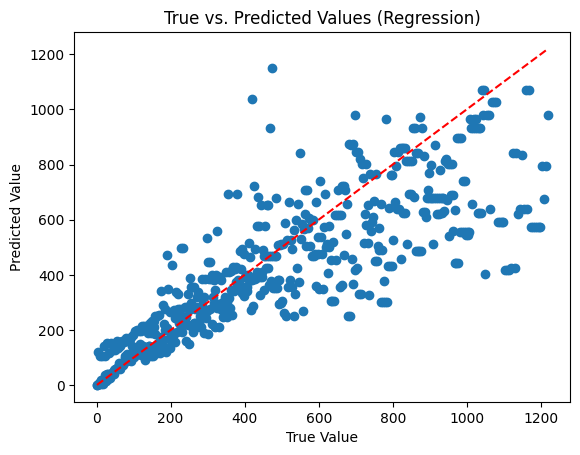


Best Linear Regression parameters: {'regressor__fit_intercept': True}

Linear Regression Test Metrics:
MSE: 0.0146, R2: 0.5085, MAE: 0.1027


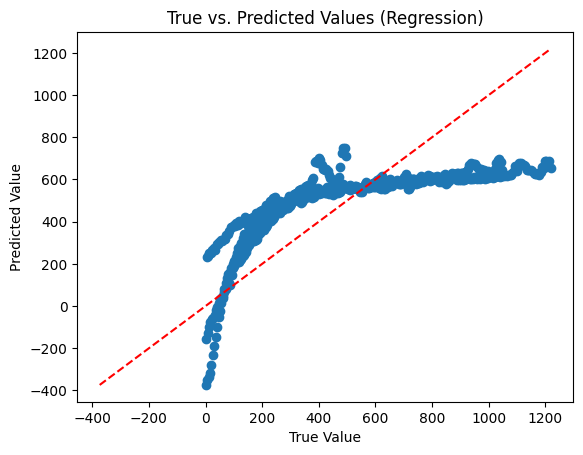

/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.176e+01, tolerance: 3.509e-02
  model = cd_fast.enet_coordinate_descent(
/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e+01, tolerance: 3.538e-01
  model = cd_fast.enet_coordinate_descent(
/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec


Best Lasso Regression parameters: {'regressor__alpha': 0.0001, 'regressor__max_iter': 1000, 'regressor__selection': 'random', 'regressor__tol': 0.001}

Lasso Regression Test Metrics:
MSE: 0.0146, R2: 0.5082, MAE: 0.1026


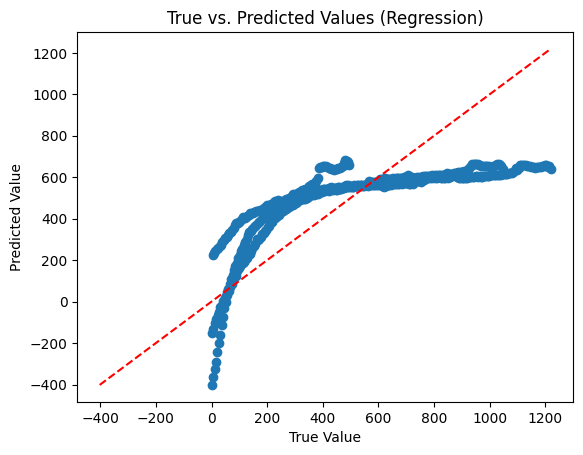

In [7]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Flatten data (assuming X_train has shape: (n_samples, timesteps, n_features))
n_samples, timesteps, n_features = X_train.shape
X_train_flat = X_train.reshape(n_samples, timesteps * n_features)
X_val_flat   = X_val.reshape(X_val.shape[0], timesteps * n_features)
X_test_flat  = X_test.reshape(X_test.shape[0], timesteps * n_features)


# --- Assume X_train_flat, X_val_flat, X_test_flat, y_train_reg, y_val_reg, y_test_reg, metadata, and plot_true_vs_pred are pre-loaded ---

# ============================
# Decision Tree Regressor
# ============================
param_grid_dt = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_regressor = DecisionTreeRegressor(random_state=42)
grid_dt = GridSearchCV(dt_regressor, param_grid_dt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_dt.fit(X_train_flat, y_train_reg)

best_dt = grid_dt.best_estimator_
print("Best Decision Tree Regressor parameters:", grid_dt.best_params_)

# Evaluate on test set
y_test_pred_dt = best_dt.predict(X_test_flat)
mse_test_dt = mean_squared_error(y_test_reg, y_test_pred_dt)
r2_test_dt  = r2_score(y_test_reg, y_test_pred_dt)
mae_test_dt = mean_absolute_error(y_test_reg, y_test_pred_dt)
print("\nDecision Tree Test Metrics:")
print(f"MSE: {mse_test_dt:.4f}, R2: {r2_test_dt:.4f}, MAE: {mae_test_dt:.4f}")

# Optionally, plot predictions for Decision Tree
plot_true_vs_pred(y_test_reg, y_test_pred_dt, y_max=metadata["y_max"])

# ============================
# Linear Regression (with scaling)
# ============================
param_grid_lr = {
    'regressor__fit_intercept': [True, False]
}
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_lr.fit(X_train_flat, y_train_reg)

best_lr = grid_lr.best_estimator_
print("\nBest Linear Regression parameters:", grid_lr.best_params_)

# Evaluate on test set
y_test_pred_lr = best_lr.predict(X_test_flat)
mse_test_lr = mean_squared_error(y_test_reg, y_test_pred_lr)
r2_test_lr  = r2_score(y_test_reg, y_test_pred_lr)
mae_test_lr = mean_absolute_error(y_test_reg, y_test_pred_lr)
print("\nLinear Regression Test Metrics:")
print(f"MSE: {mse_test_lr:.4f}, R2: {r2_test_lr:.4f}, MAE: {mae_test_lr:.4f}")

# Optionally, plot predictions for Linear Regression
plot_true_vs_pred(y_test_reg, y_test_pred_lr, y_max=metadata["y_max"])

# ============================
# Lasso Regression (with scaling)
# ============================
param_grid_lasso = {
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'regressor__max_iter': [1000, 5000, 10000],
    'regressor__tol': [0.0001, 0.001],
    'regressor__selection': ['cyclic', 'random']
}
pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso())
])
grid_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_lasso.fit(X_train_flat, y_train_reg)

best_lasso = grid_lasso.best_estimator_
print("\nBest Lasso Regression parameters:", grid_lasso.best_params_)

# Evaluate on test set
y_test_pred_lasso = best_lasso.predict(X_test_flat)
mse_test_lasso = mean_squared_error(y_test_reg, y_test_pred_lasso)
r2_test_lasso  = r2_score(y_test_reg, y_test_pred_lasso)
mae_test_lasso = mean_absolute_error(y_test_reg, y_test_pred_lasso)
print("\nLasso Regression Test Metrics:")
print(f"MSE: {mse_test_lasso:.4f}, R2: {r2_test_lasso:.4f}, MAE: {mae_test_lasso:.4f}")

# Optionally, plot predictions for Lasso Regression
plot_true_vs_pred(y_test_reg, y_test_pred_lasso, y_max=metadata["y_max"])


Decision Tree Regressor:
Validation MSE: 0.0164, R2: 0.4503
Test MSE: 0.0187, R2: 0.3691
Test MAE: 0.1097741836131653


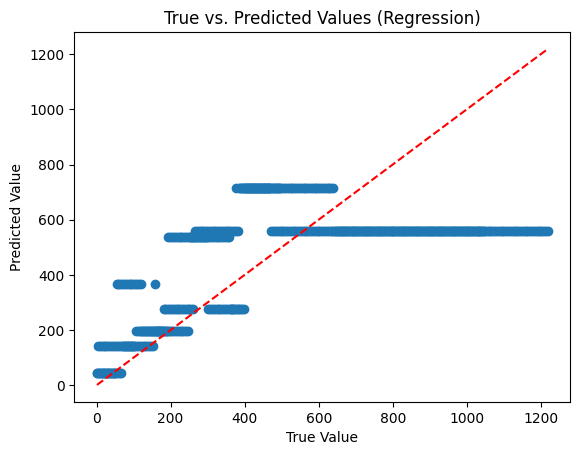


Linear Regression:
Validation MSE: 0.0184, R2: 0.3847
Test MSE: 0.0146, R2: 0.5085
Test MAE: 0.10274956582495551


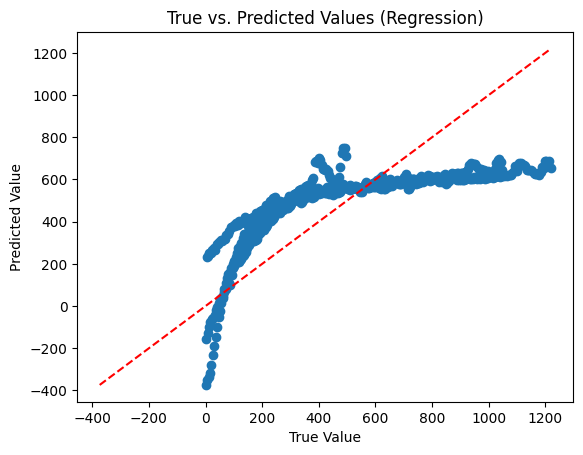


Lasso Regression:
Validation MSE: 0.0180, R2: 0.3961
Test MSE: 0.0146, R2: 0.5085
Test MAE: 0.10260194439778283


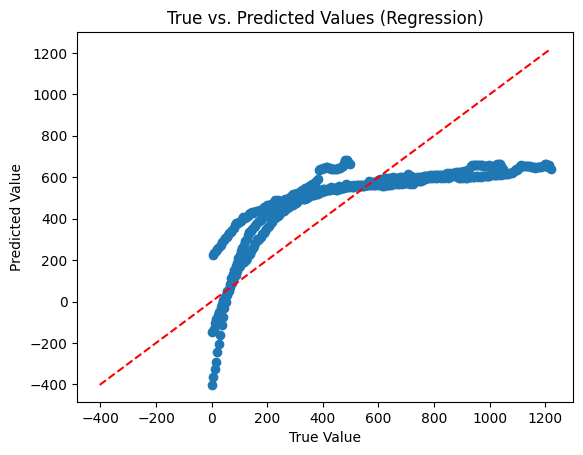

In [16]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- Assume X_train, X_val, X_test, y_train_reg, y_val_reg, y_test_reg, metadata, and plot_true_vs_pred are pre-loaded ---

# Flatten data (assuming X_train has shape: (n_samples, timesteps, n_features))
n_samples, timesteps, n_features = X_train.shape
X_train_flat = X_train.reshape(n_samples, timesteps * n_features)
X_val_flat   = X_val.reshape(X_val.shape[0], timesteps * n_features)
X_test_flat  = X_test.reshape(X_test.shape[0], timesteps * n_features)

# =============================
# Decision Tree Regressor
# =============================
dt_regressor = DecisionTreeRegressor(random_state=42, max_depth=3)
dt_regressor.fit(X_train_flat, y_train_reg)

# Predictions
y_val_pred_dt  = dt_regressor.predict(X_val_flat)
y_test_pred_dt = dt_regressor.predict(X_test_flat)

# Metrics
mse_val_dt = mean_squared_error(y_val_reg, y_val_pred_dt)
r2_val_dt  = r2_score(y_val_reg, y_val_pred_dt)
mse_test_dt = mean_squared_error(y_test_reg, y_test_pred_dt)
r2_test_dt  = r2_score(y_test_reg, y_test_pred_dt)
mae_test_dt = mean_absolute_error(y_test_reg, y_test_pred_dt)
mae_test_dt_rescaled = mae_test_dt * metadata["y_max"]

print("Decision Tree Regressor:")
print(f"Validation MSE: {mse_val_dt:.4f}, R2: {r2_val_dt:.4f}")
print(f"Test MSE: {mse_test_dt:.4f}, R2: {r2_test_dt:.4f}")
print(f"Test MAE: {mae_test_dt}")

# Plot predictions for validation and test sets
plot_true_vs_pred(y_test_reg, y_test_pred_dt, y_max=metadata["y_max"])

# =============================
# Linear Regression
# =============================
lin_reg = LinearRegression()
lin_reg.fit(X_train_flat, y_train_reg)

# Predictions
y_val_pred_lr  = lin_reg.predict(X_val_flat)
y_test_pred_lr = lin_reg.predict(X_test_flat)

# Metrics
mse_val_lr = mean_squared_error(y_val_reg, y_val_pred_lr)
r2_val_lr  = r2_score(y_val_reg, y_val_pred_lr)
mse_test_lr = mean_squared_error(y_test_reg, y_test_pred_lr)
r2_test_lr  = r2_score(y_test_reg, y_test_pred_lr)
mae_test_lr = mean_absolute_error(y_test_reg, y_test_pred_lr)
mae_test_lr_rescaled = mae_test_lr * metadata["y_max"]

print("\nLinear Regression:")
print(f"Validation MSE: {mse_val_lr:.4f}, R2: {r2_val_lr:.4f}")
print(f"Test MSE: {mse_test_lr:.4f}, R2: {r2_test_lr:.4f}")
print(f"Test MAE: {mae_test_lr}")

# Plot predictions (using only the test set here)
plot_true_vs_pred(y_test_reg, y_test_pred_lr, y_max=metadata["y_max"])

# =============================
# Lasso Regression
# =============================
lasso_reg = Lasso(alpha=0.0001, max_iter=10000)
lasso_reg.fit(X_train_flat, y_train_reg)

# Predictions
y_val_pred_lasso  = lasso_reg.predict(X_val_flat)
y_test_pred_lasso = lasso_reg.predict(X_test_flat)

# Metrics
mse_val_lasso = mean_squared_error(y_val_reg, y_val_pred_lasso)
r2_val_lasso  = r2_score(y_val_reg, y_val_pred_lasso)
mse_test_lasso = mean_squared_error(y_test_reg, y_test_pred_lasso)
r2_test_lasso  = r2_score(y_test_reg, y_test_pred_lasso)
mae_test_lasso = mean_absolute_error(y_test_reg, y_test_pred_lasso)
mae_test_lasso_rescaled = mae_test_lasso * metadata["y_max"]

print("\nLasso Regression:")
print(f"Validation MSE: {mse_val_lasso:.4f}, R2: {r2_val_lasso:.4f}")
print(f"Test MSE: {mse_test_lasso:.4f}, R2: {r2_test_lasso:.4f}")
print(f"Test MAE: {mae_test_lasso}")

# Plot predictions (using only the test set here)
plot_true_vs_pred(y_test_reg, y_test_pred_lasso, y_max=metadata["y_max"])


In [17]:


# Example reshaping assuming X_train has shape (n_samples, timesteps, n_features)
n_samples, timesteps, n_features = X_train.shape

# Reshape data by flattening the time dimension
X_train_flat = X_train.reshape(n_samples, timesteps * n_features)
X_val_flat = X_val.reshape(X_val.shape[0], timesteps * n_features)
X_test_flat = X_test.reshape(X_test.shape[0], timesteps * n_features)

# -----------------------------
# Train Decision Tree Regressor
# -----------------------------
dt_regressor = DecisionTreeRegressor(random_state=42, max_depth=3)
dt_regressor.fit(X_train_flat, y_train_reg)

# Make predictions on validation and test sets
y_val_pred_dt = dt_regressor.predict(X_val_flat)
y_test_pred_dt = dt_regressor.predict(X_test_flat)

# Evaluate Decision Tree Regressor performance
mse_val_dt = mean_squared_error(y_val_reg, y_val_pred_dt)
r2_val_dt = r2_score(y_val_reg, y_val_pred_dt)
mse_test_dt = mean_squared_error(y_test_reg, y_test_pred_dt)
r2_test_dt = r2_score(y_test_reg, y_test_pred_dt)

print("Decision Tree Regressor:")
print(f"Validation MSE: {mse_val_dt:.4f}, R2: {r2_val_dt:.4f}")
print(f"Test MSE: {mse_test_dt:.4f}, R2: {r2_test_dt:.4f}")

mae_test_dt = mean_absolute_error(y_test_reg, y_test_pred_dt)
mae_test_dt_rescaled = mae_test_dt * metadata["y_max"]
print(f"Test MAE: {mae_test_dt}")

# -----------------------------
# Train Linear Regression Model
# -----------------------------
lin_reg = LinearRegression()
lin_reg.fit(X_train_flat, y_train_reg)

# Make predictions on validation and test sets
y_val_pred_lr = lin_reg.predict(X_val_flat)
y_test_pred_lr = lin_reg.predict(X_test_flat)

# Evaluate Linear Regression performance
mse_val_lr = mean_squared_error(y_val_reg, y_val_pred_lr)
r2_val_lr = r2_score(y_val_reg, y_val_pred_lr)
mse_test_lr = mean_squared_error(y_test_reg, y_test_pred_lr)
r2_test_lr = r2_score(y_test_reg, y_test_pred_lr)

print("Linear Regression:")
print(f"Validation MSE: {mse_val_lr:.4f}, R2: {r2_val_lr:.4f}")
print(f"Test MSE: {mse_test_lr:.4f}, R2: {r2_test_lr:.4f}")

mae_test_lr = mean_absolute_error(y_test_reg, y_test_pred_lr)
mae_test_lr_rescaled = mae_test_lr * metadata["y_max"]
print(f"Test MAE: {mae_test_lr}")

Decision Tree Regressor:
Validation MSE: 0.0164, R2: 0.4503
Test MSE: 0.0187, R2: 0.3691
Test MAE: 0.1097741836131653
Linear Regression:
Validation MSE: 0.0184, R2: 0.3847
Test MSE: 0.0146, R2: 0.5085
Test MAE: 0.10274956582495551


Decision Tree Regressor:
Validation MSE: 0.0164, R2: 0.4503
Test MSE: 0.0187, R2: 0.3691



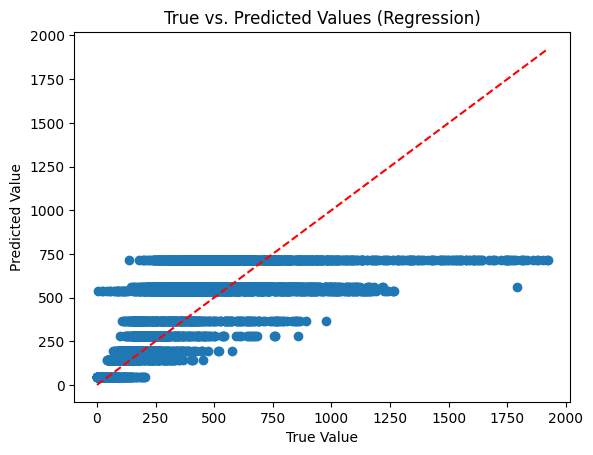

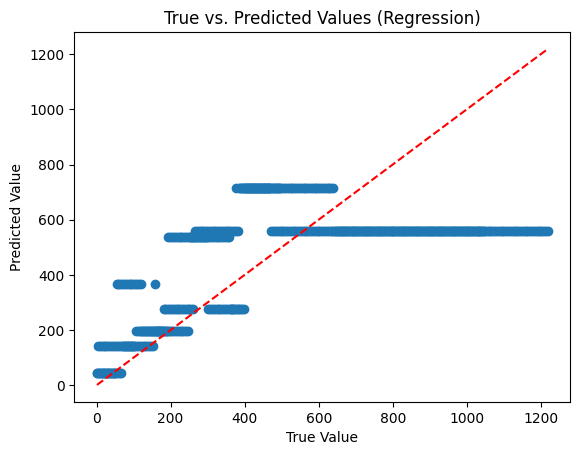

Linear Regression:
Validation MSE: 0.0184, R2: 0.3847
Test MSE: 0.0146, R2: 0.5085


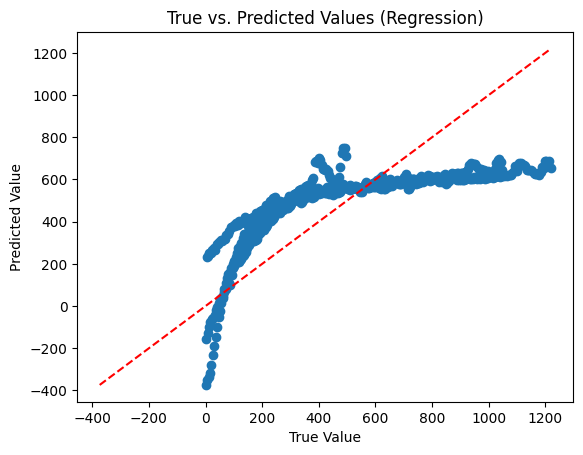

Lasso Regression:
Validation MSE: 0.0184, R2: 0.3847
Test MSE: 0.0146, R2: 0.5085


/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.114e+01, tolerance: 4.443e-02



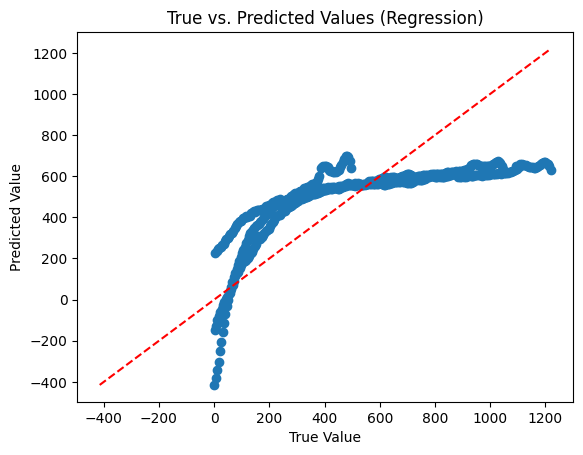

In [18]:
# Assume X_train, X_val, X_test, y_train_reg, y_val_reg, y_test_reg, and metadata are pre-loaded.
# Also assume that the data has shape (n_samples, timesteps, n_features).
# We flatten the time dimension for these models.
n_samples, timesteps, n_features = X_train.shape

X_train_flat = X_train.reshape(n_samples, timesteps * n_features)
X_val_flat = X_val.reshape(X_val.shape[0], timesteps * n_features)
X_test_flat = X_test.reshape(X_test.shape[0], timesteps * n_features)

# -----------------------------
# Train Decision Tree Regressor
# -----------------------------
dt_regressor = DecisionTreeRegressor(random_state=42, max_depth=3)
dt_regressor.fit(X_train_flat, y_train_reg)
y_test_pred_dt = dt_regressor.predict(X_test_flat)

# Evaluate using the custom plotting function
print("Decision Tree Regressor:")
print(f"Validation MSE: {mse_val_dt:.4f}, R2: {r2_val_dt:.4f}")
print(f"Test MSE: {mse_test_dt:.4f}, R2: {r2_test_dt:.4f}\n")
plot_true_vs_pred(y_val_reg, y_val_pred_dt, y_max=metadata["y_max"])
plot_true_vs_pred(y_test_reg, y_test_pred_dt, y_max=metadata["y_max"])


# -----------------------------
# Train Linear Regression Model
# -----------------------------
lin_reg = LinearRegression()
lin_reg.fit(X_train_flat, y_train_reg)
y_test_pred_lr = lin_reg.predict(X_test_flat)

# Evaluate using the custom plotting function
print("Linear Regression:")
print(f"Validation MSE: {mse_val_lr:.4f}, R2: {r2_val_lr:.4f}")
print(f"Test MSE: {mse_test_lr:.4f}, R2: {r2_test_lr:.4f}")
plot_true_vs_pred(y_test_reg, y_test_pred_lr, y_max=metadata["y_max"])

# -----------------------------
# Train Lasso Regression Model
# -----------------------------

from sklearn.linear_model import Lasso
lin_reg = Lasso(alpha=0.0001)
lin_reg.fit(X_train_flat, y_train_reg)
y_test_pred_lr = lin_reg.predict(X_test_flat)

# Evaluate using the custom plotting function
print("Lasso Regression:")
print(f"Validation MSE: {mse_val_lr:.4f}, R2: {r2_val_lr:.4f}")
print(f"Test MSE: {mse_test_lr:.4f}, R2: {r2_test_lr:.4f}")
plot_true_vs_pred(y_test_reg, y_test_pred_lr, y_max=metadata["y_max"])


Decision Tree Feature Importances:
          Feature  Importance
118  timestep_118    0.707948
119  timestep_119    0.157632
0      timestep_0    0.134420
3      timestep_3    0.000000
77    timestep_77    0.000000
..            ...         ...
38    timestep_38    0.000000
37    timestep_37    0.000000
36    timestep_36    0.000000
35    timestep_35    0.000000
60    timestep_60    0.000000

[120 rows x 2 columns]


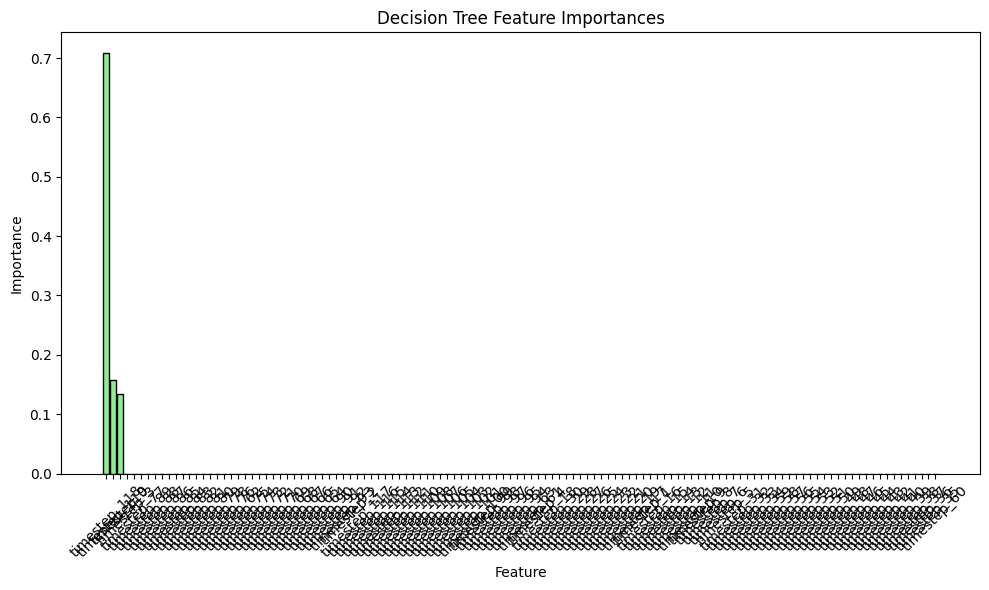

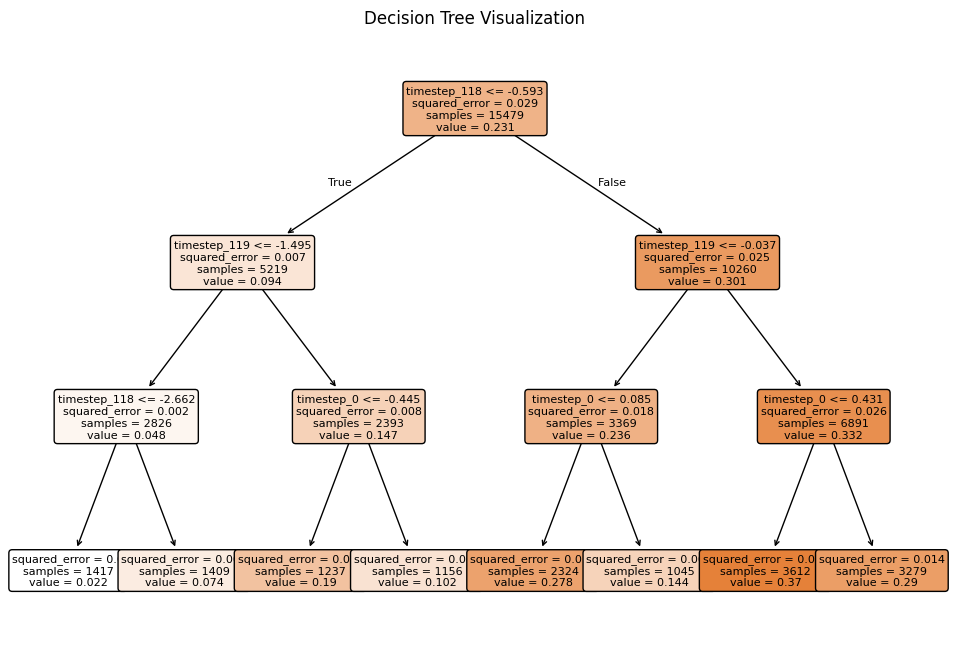

Linear Regression Coefficients:
          Feature  Coefficient
1      timestep_1    -0.069114
2      timestep_2    -0.047293
115  timestep_115     0.042820
118  timestep_118     0.038143
110  timestep_110     0.035559
..            ...          ...
38    timestep_38     0.000000
37    timestep_37     0.000000
36    timestep_36     0.000000
34    timestep_34     0.000000
119  timestep_119     0.000000

[120 rows x 2 columns]


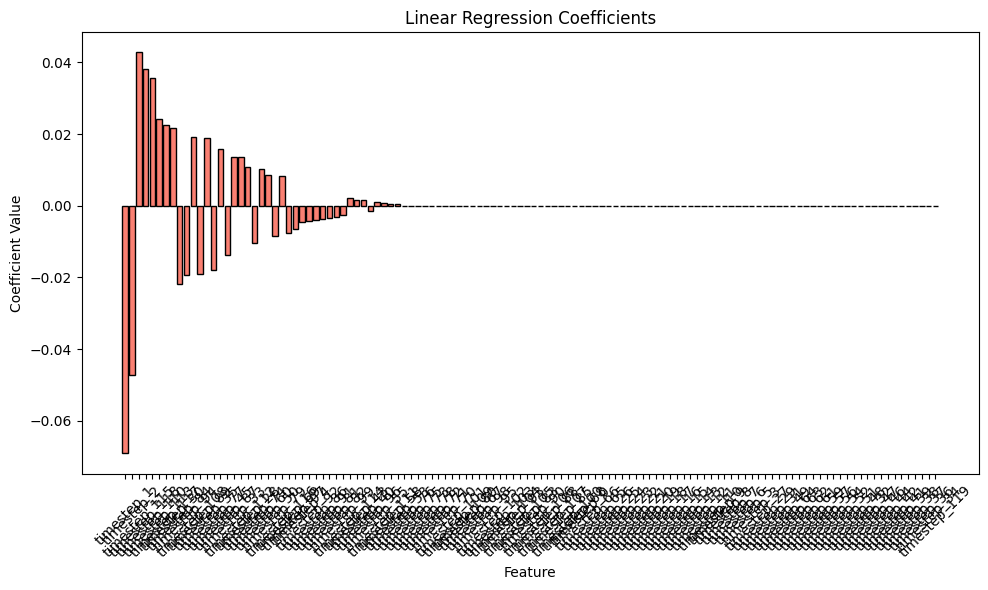

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import plot_tree

# Create a feature name list for each timestep:
feature_names = [f"timestep_{i}" for i in range(120)]

# --------------------------
# 2. Decision Tree Regressor: Feature Importances and Tree Plot
# --------------------------
# Assume:
#   dt_model is your fitted DecisionTreeRegressor.
#   feature_names is a list of feature names corresponding to the columns of your data.

# Print feature importances:
dt_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_regressor.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Decision Tree Feature Importances:")
print(dt_importances)

# Optionally, plot the feature importances as a bar chart:
plt.figure(figsize=(10, 6))
plt.bar(dt_importances['Feature'], dt_importances['Importance'], color='lightgreen', edgecolor='k')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Decision Tree Feature Importances")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# You can also visualize the tree (for small trees) using plot_tree:
plt.figure(figsize=(12, 8))
plot_tree(dt_regressor, feature_names=feature_names, filled=True, rounded=True, fontsize=8)
plt.title("Decision Tree Visualization")
plt.show()

# --------------------------
# 3. Linear Regression: Coefficients
# --------------------------
# Assume:
#   lin_reg is your fitted LinearRegression model.

# Create a DataFrame for the coefficients:
lin_coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lin_reg.coef_
}).sort_values(by='Coefficient', key=lambda x: np.abs(x), ascending=False)
print("Linear Regression Coefficients:")
print(lin_coefs)

# Plot the coefficients as a bar chart:
plt.figure(figsize=(10, 6))
plt.bar(lin_coefs['Feature'], lin_coefs['Coefficient'], color='salmon', edgecolor='k')
plt.xlabel("Feature")
plt.ylabel("Coefficient Value")
plt.title("Linear Regression Coefficients")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


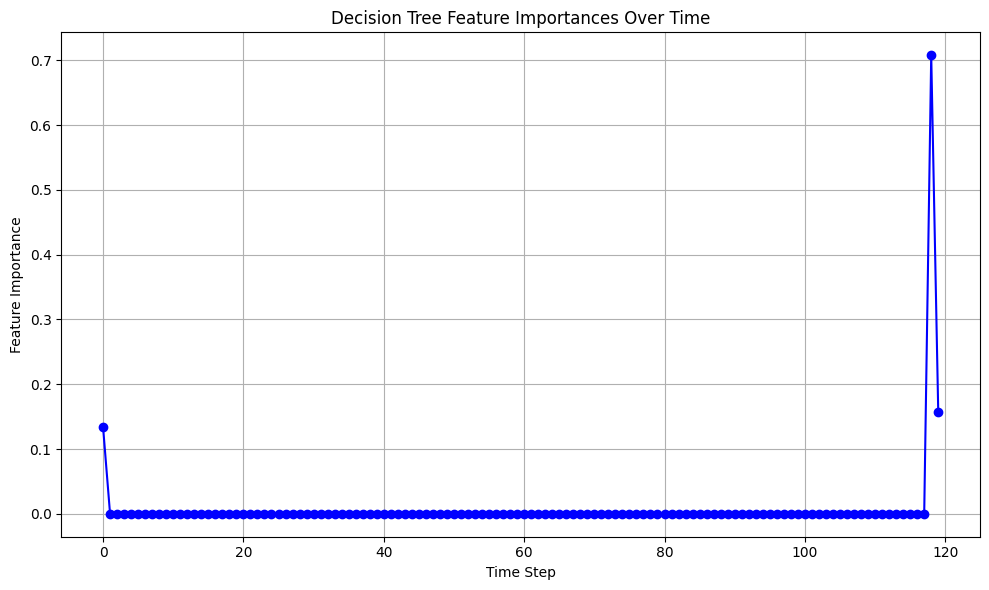

Decision Tree Feature Importances (by timestep):
          Feature  Timestep  Importance
0      timestep_0         0    0.134420
1      timestep_1         1    0.000000
2      timestep_2         2    0.000000
3      timestep_3         3    0.000000
4      timestep_4         4    0.000000
..            ...       ...         ...
115  timestep_115       115    0.000000
116  timestep_116       116    0.000000
117  timestep_117       117    0.000000
118  timestep_118       118    0.707948
119  timestep_119       119    0.157632

[120 rows x 3 columns]


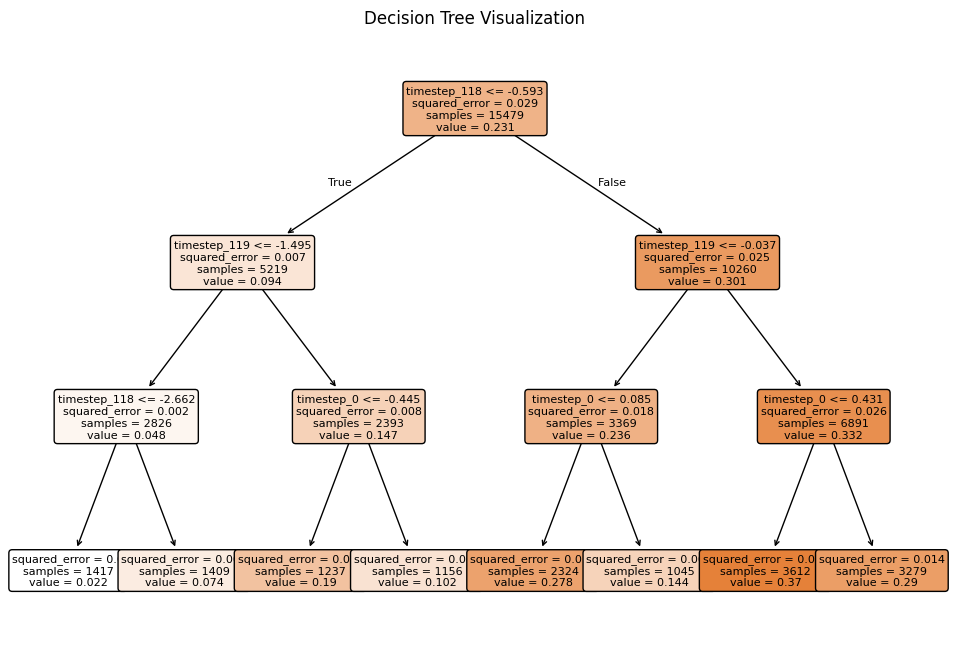

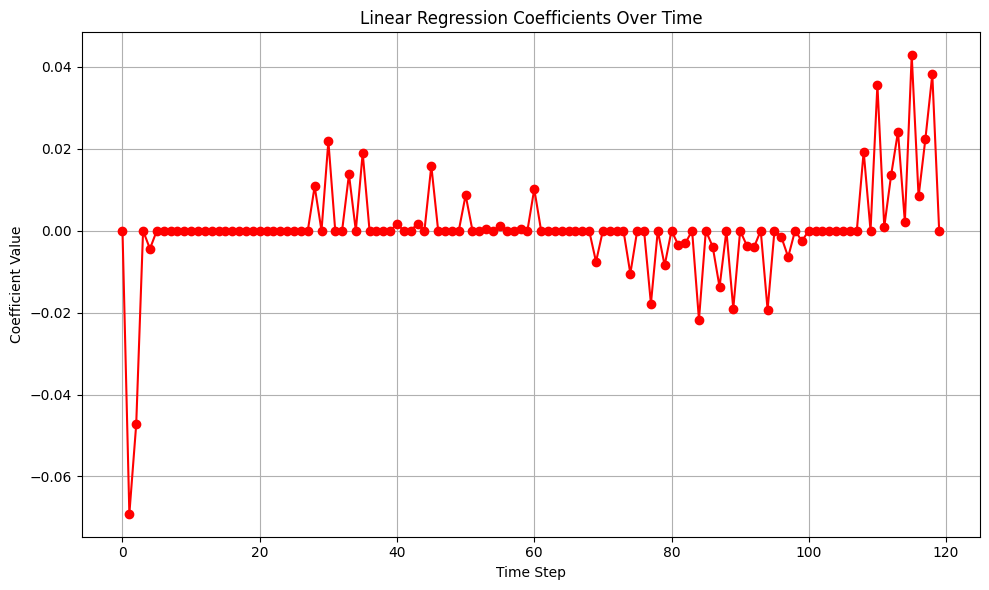

Linear Regression Coefficients (by timestep):
          Feature  Timestep  Coefficient
0      timestep_0         0    -0.000000
1      timestep_1         1    -0.069114
2      timestep_2         2    -0.047293
3      timestep_3         3    -0.000000
4      timestep_4         4    -0.004430
..            ...       ...          ...
115  timestep_115       115     0.042820
116  timestep_116       116     0.008347
117  timestep_117       117     0.022485
118  timestep_118       118     0.038143
119  timestep_119       119     0.000000

[120 rows x 3 columns]


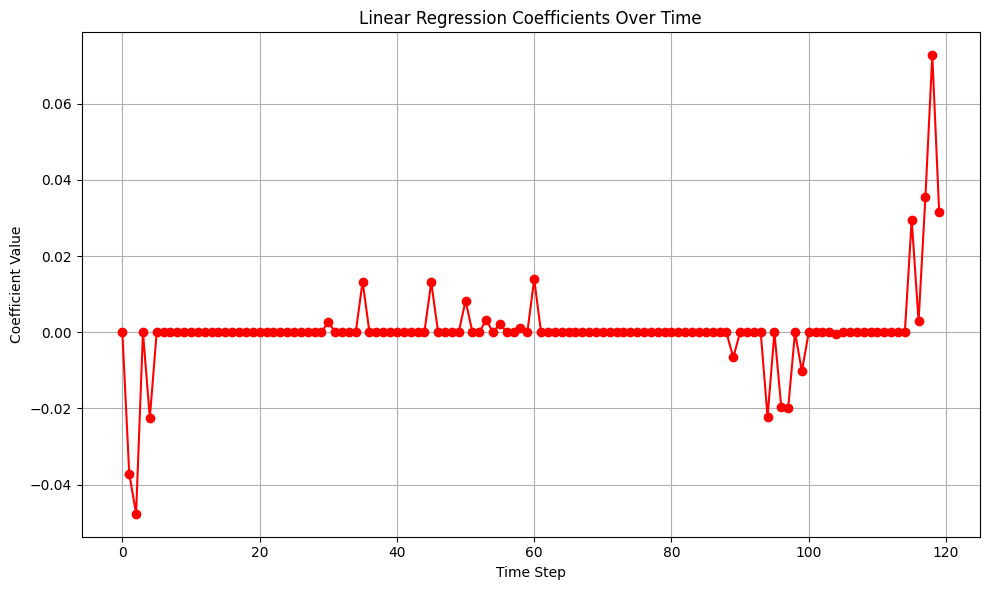

Linear Regression Coefficients (by timestep):
          Feature  Timestep  Coefficient
0      timestep_0         0    -0.000000
1      timestep_1         1    -0.037064
2      timestep_2         2    -0.047627
3      timestep_3         3    -0.000000
4      timestep_4         4    -0.022446
..            ...       ...          ...
115  timestep_115       115     0.029496
116  timestep_116       116     0.002922
117  timestep_117       117     0.035551
118  timestep_118       118     0.072683
119  timestep_119       119     0.031636

[120 rows x 3 columns]


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import plot_tree

# --- Decision Tree Regressor: Continuous Plot of Feature Importances ---
# Assume:
#   dt_regressor is your fitted DecisionTreeRegressor.
#   feature_names is a list of feature names (e.g., ['timestep_0', 'timestep_1', ..., 'timestep_119']).

# Convert feature names to numeric timesteps.
# This example assumes each feature name ends with an underscore followed by the timestep number.
timesteps = np.array([int(f.split('_')[-1]) for f in feature_names])

# Retrieve the feature importances:
importance_values = dt_regressor.feature_importances_

# Create a continuous line plot:
plt.figure(figsize=(10, 6))
plt.plot(timesteps, importance_values, marker='o', linestyle='-', color='blue')
plt.xlabel("Time Step")
plt.ylabel("Feature Importance")
plt.title("Decision Tree Feature Importances Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# You can still print the DataFrame if you want:
dt_importances = pd.DataFrame({
    'Feature': feature_names,
    'Timestep': timesteps,
    'Importance': importance_values
}).sort_values(by='Timestep')
print("Decision Tree Feature Importances (by timestep):")
print(dt_importances)

# Optionally, you may still visualize the tree structure (note: this plot remains a tree view):
plt.figure(figsize=(12, 8))
plot_tree(dt_regressor, feature_names=feature_names, filled=True, rounded=True, fontsize=8)
plt.title("Decision Tree Visualization")
plt.show()

# --- Linear Regression: Continuous Plot of Coefficients ---
# Assume:
#   lin_reg is your fitted LinearRegression model.

# Get the coefficients and convert them similarly:
coeff_values = lin_reg.coef_

# Create a continuous line plot:
plt.figure(figsize=(10, 6))
plt.plot(timesteps, coeff_values, marker='o', linestyle='-', color='red')
plt.xlabel("Time Step")
plt.ylabel("Coefficient Value")
plt.title("Linear Regression Coefficients Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# Also, print the coefficients in a DataFrame (sorted by timestep):
lin_coefs = pd.DataFrame({
    'Feature': feature_names,
    'Timestep': timesteps,
    'Coefficient': coeff_values
}).sort_values(by='Timestep')
print("Linear Regression Coefficients (by timestep):")
print(lin_coefs)


# --- Linear Regression: Continuous Plot of Coefficients ---
# Assume:
#   lin_reg is your fitted LinearRegression model.

# Get the coefficients and convert them similarly:
coeff_values = lasso_reg.coef_

# Create a continuous line plot:
plt.figure(figsize=(10, 6))
plt.plot(timesteps, coeff_values, marker='o', linestyle='-', color='red')
plt.xlabel("Time Step")
plt.ylabel("Coefficient Value")
plt.title("Linear Regression Coefficients Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# Also, print the coefficients in a DataFrame (sorted by timestep):
lin_coefs = pd.DataFrame({
    'Feature': feature_names,
    'Timestep': timesteps,
    'Coefficient': coeff_values
}).sort_values(by='Timestep')
print("Linear Regression Coefficients (by timestep):")
print(lin_coefs)


### Classification

#### 1D Convolutional Neural Network

In [12]:
cnn_model = load_saved_model(model_task = "cnn_classification", config=config)

# Generate predictions
y_test_pred_cnn = cnn_model.predict(X_test)

# Evaluate
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test, y_test_clf, verbose=0)
print(f"Test Loss: {test_loss_cnn:.4f}")
print(f"Test Accuracy: {test_acc_cnn:.4f}")

# Classification report
y_test_pred_cnn_classes = np.argmax(y_test_pred_cnn, axis=1)
y_test_classes = np.argmax(y_test_clf, axis=1)
print(classification_report(y_test_classes, y_test_pred_cnn_classes))


# Confusion matrix
cm = confusion_matrix(y_test_classes, y_test_pred_cnn_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classification_labels, yticklabels=classification_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


AttributeError: 'NoneType' object has no attribute 'predict'

#### Decision Tree

In [8]:
# Preparation and Tuning for Decision Tree

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Convert one-hot encoded labels to integer labels
y_train_true = np.argmax(y_train_clf, axis=1)
y_test_true = np.argmax(y_test_clf, axis=1)

# Define the hyperparameter grid for the Decision Tree
dt_param_grid = {
    'max_depth': [2,3, 5],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV with 5-fold cross-validation
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1),
                              dt_param_grid,
                              cv=5,
                              scoring='accuracy')

# Fit the grid search on the flattened training data
dt_grid_search.fit(X_train_flat, y_train_true)

# Print the best parameters and corresponding cross-validation accuracy
print("Best parameters for Decision Tree:", dt_grid_search.best_params_)
print("Best cross-validation accuracy:", dt_grid_search.best_score_)

# Store the best estimator for later evaluation
best_dt_classifier = dt_grid_search.best_estimator_


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}
Best cross-validation accuracy: 0.5928693650256938


Decision Tree Test Accuracy with best parameters: 0.6823
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       120
           1       0.69      0.54      0.61       120
           2       0.00      0.00      0.00       100
           3       0.62      1.00      0.77       214

    accuracy                           0.68       554
   macro avg       0.56      0.59      0.56       554
weighted avg       0.59      0.68      0.62       554



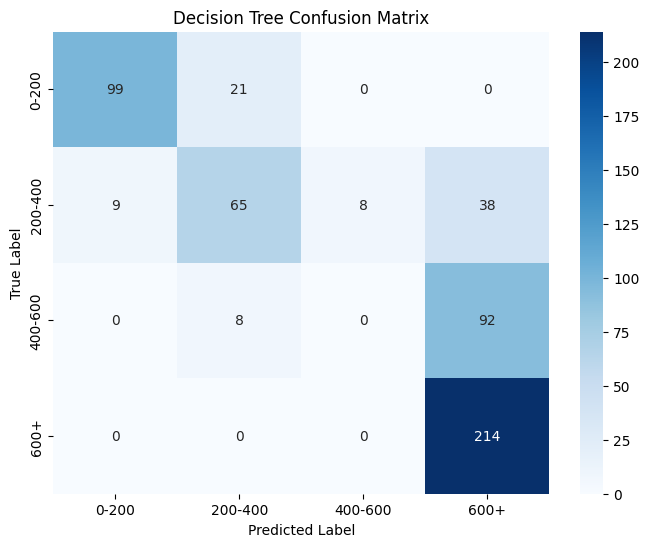

In [9]:
# Evaluation for the Tuned Decision Tree

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the tuned Decision Tree on the flattened test data
test_acc_dt = best_dt_classifier.score(X_test_flat, y_test_true)
print("Decision Tree Test Accuracy with best parameters: {:.4f}".format(test_acc_dt))

# Make predictions on the validation and test sets using the tuned model
y_val_pred_dt = best_dt_classifier.predict(X_val_flat)
y_test_pred_dt = best_dt_classifier.predict(X_test_flat)

# Print the classification report for Decision Tree predictions
print(classification_report(y_test_true, y_test_pred_dt))

# Generate the confusion matrix for Decision Tree predictions
cm_dt = confusion_matrix(y_test_true, y_test_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classification_labels, yticklabels=classification_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Decision Tree Confusion Matrix")
plt.show()


#### Logistic regression

In [10]:
# Preparation and Tuning for Logistic Regression

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Convert one-hot encoded labels to integer labels
y_train_true = np.argmax(y_train_clf, axis=1)
y_test_true = np.argmax(y_test_clf, axis=1)

# Define the hyperparameter grid for Logistic Regression
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'max_iter': [1000]
}

# Initialize GridSearchCV with 5-fold cross-validation
lr_grid_search = GridSearchCV(LogisticRegression(random_state=1),
                              lr_param_grid,
                              cv=5,
                              scoring='accuracy')

# Fit the grid search on the flattened training data
lr_grid_search.fit(X_train_flat, y_train_true)

# Print the best parameters and corresponding cross-validation accuracy
print("Best parameters for Logistic Regression:", lr_grid_search.best_params_)
print("Best cross-validation accuracy:", lr_grid_search.best_score_)

# Store the best estimator for later evaluation
best_lr_classifier = lr_grid_search.best_estimator_


/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best parameters for Logistic Regression: {'C': 1, 'max_iter': 1000, 'penalty': 'l2'}
Best cross-validation accuracy: 0.7167136917508861


Logistic Regression Test Accuracy with best parameters: 0.7329
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       120
           1       0.63      0.82      0.71       120
           2       0.31      0.08      0.13       100
           3       0.76      0.95      0.84       214

    accuracy                           0.73       554
   macro avg       0.66      0.66      0.64       554
weighted avg       0.69      0.73      0.69       554



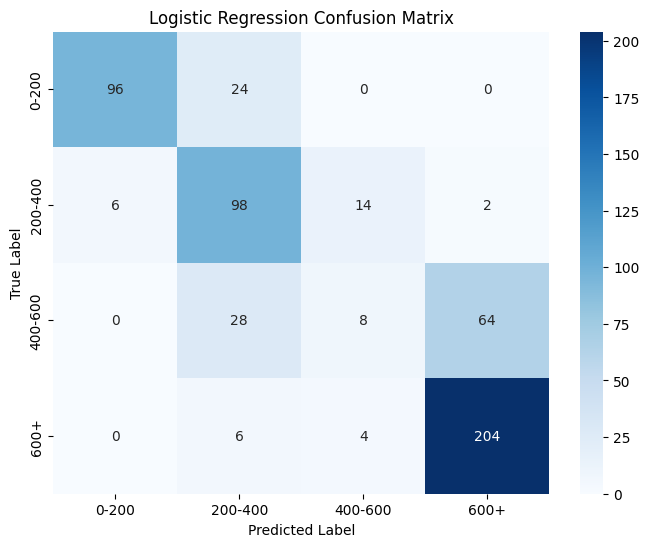

In [11]:
# Evaluation for the Tuned Logistic Regression Model

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the tuned Logistic Regression on the flattened test data
test_acc_lr = best_lr_classifier.score(X_test_flat, y_test_true)
print("Logistic Regression Test Accuracy with best parameters: {:.4f}".format(test_acc_lr))

# Make predictions on the validation and test sets using the tuned model
y_val_pred_lr = best_lr_classifier.predict(X_val_flat)
y_test_pred_lr = best_lr_classifier.predict(X_test_flat)

# Print the classification report for Logistic Regression predictions
print(classification_report(y_test_true, y_test_pred_lr))

# Generate the confusion matrix for Logistic Regression predictions
cm_lr = confusion_matrix(y_test_true, y_test_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classification_labels, yticklabels=classification_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


## Ante-Hoc Explainability Methods

### Regression

#### SHAP

X_train_2d shape: (15479, 120)
X_test_2d shape: (554, 120)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[('timestep_119 > 0.31', 0.2248906608256791), ('timestep_118 > 0.31', 0.05456347651480765), ('timestep_117 > 0.31', 0.022568889579853788), ('timestep_106 > 0.32', -0.019534330141555326), ('timestep_111 > 0.31', -0.01789642817794506), ('timestep_108 > 0.32', -0.016915415355690012), ('timestep_95 > 0.33', -0.01685054824479864), ('timestep_116 > 0.31', 0.015163681012974993), ('timestep_100 > 0.32', -0.01514042189590566), ('timestep_97 > 0.33', -0.014900340075308124), ('timestep_105 > 0.32', -0.014804926684982404), ('timestep_103 > 0.32', -0.014220412679633292), ('timestep_76 > 0.34', -0.013037211109598953), ('timestep_109 > 0.32', -0.012904614353798319), ('timestep_110 > 0.32', -0.01257612223743839), ('timestep_102 > 0.32', -0.011993152007298795), ('timestep_57 > 0.36', 0.01194598304685392), ('timestep_94 > 0.33', -0.011645036730135748), ('timestep_107 > 0.32', -0.011376927119727666), ('tim

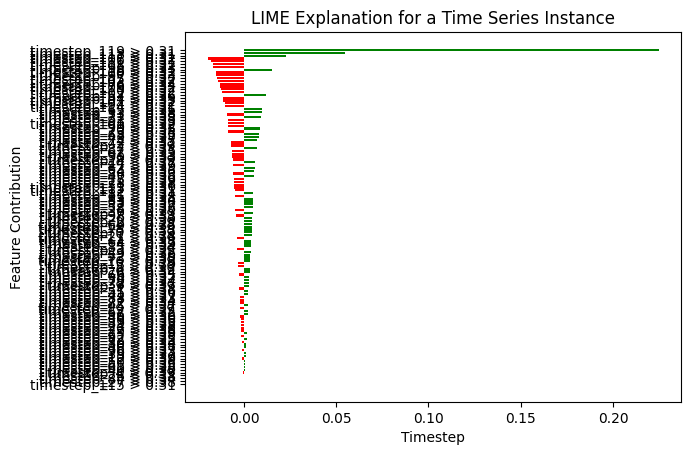

In [ ]:
import numpy as np
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Assume X_train and X_test have shape (n_samples, 120, 1)
# Reshape to 2D: each sample becomes a 1D vector with 120 timesteps.
X_train_2d = X_train.reshape(X_train.shape[0], -1)  # (n_train, 120)
X_test_2d = X_test.reshape(X_test.shape[0], -1)     # (n_test, 120)

print("X_train_2d shape:", X_train_2d.shape)
print("X_test_2d shape:", X_test_2d.shape)

# Create a feature name list for each timestep:
feature_names = [f"timestep_{i}" for i in range(120)]

# Define a prediction wrapper that converts a 2D input to the model's expected 3D shape.
def predict_wrapper_lstm(X):
    # X is a 2D array of shape (n, 120); reshape to (n, 120, 1) for the LSTM model.
    return lstm_model.predict(X.reshape(-1, 120, 1))

# Initialize the LIME explainer for regression.
explainer = LimeTabularExplainer(
    training_data=X_train_2d,
    feature_names=feature_names,
    mode='regression'
)

# Select one instance from the test set to explain.
instance = X_test_2d[0]  # A 1D vector of shape (120,)

# Generate a LIME explanation for the selected instance.
# 'num_features' controls how many timesteps (features) will be shown in the explanation.
explanation = explainer.explain_instance(instance, predict_wrapper_lstm, num_features=120)

# Display the explanation.
# Option 1: Show a textual representation.
print(explanation.as_list())

# Option 2: Plot the explanation as a bar plot.
fig = explanation.as_pyplot_figure()
plt.title("LIME Explanation for a Time Series Instance")
plt.xlabel("Timestep")
plt.ylabel("Feature Contribution")
plt.show()


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Get the LIME explanation as a list of tuples:
lime_explanation_list = explanation.as_list()  # e.g., [("timestep_0", 0.12), ("timestep_1", -0.05), ...]

# Convert to DataFrame:
df_lime = pd.DataFrame(lime_explanation_list, columns=["feature", "contribution"])

# Extract numeric timestep index from the feature names, assuming they follow "timestep_<number>"
df_lime["timestep_index"] = df_lime["feature"].str.extract("timestep_(\d+)").astype(int)

# Now create a Plotly bar plot using the numeric x-axis.
fig = go.Figure(data=go.Bar(
    x=df_lime["timestep_index"],
    y=df_lime["contribution"],
    marker_color="teal"
))
fig.update_layout(
    title="LIME Explanation by Timestep",
    xaxis_title="Timestep Index",
    yaxis_title="Contribution",
    xaxis=dict(tickmode="linear", dtick=10)  # dtick=10 will show ticks every 10 timesteps
)
fig.show()


In [ ]:
# Reshape the training and test data to 2D
X_train_2d = X_train.reshape(X_train.shape[0], -1)  # Shape: (n_train, 120)

# Sample a background dataset and test set. The larger the background dataset, the more accurate the SHAP values.
background = shap.sample(X_train_2d, 100)

# Create a wrapper for the model's predict function
def predict_wrapper_lstm(X):
    # Reshape X from (n, 120) to (n, 120, 1)
    return lstm_model.predict(X.reshape(-1, 120, 1))

# Initialize the KernelExplainer with the 2D background data and the wrapper function
explainer_shap = shap.KernelExplainer(predict_wrapper_lstm, background)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [ ]:
# Example: Plot the SHAP values for a single test sample

# Compute the SHAP values using the test set
X_test_2d = X_test.reshape(X_test.shape[0], -1)    # Shape: (n_test, 120)
test = shap.sample(X_test_2d, 1)

shap_values = explainer_shap.shap_values(test)

# Assuming shap_values[0] is a (120, 1) array
# Flatten it to a 1D array (120,)
shap_first = shap_values[0].flatten()

# Create the x-axis as timestep indices (0 to 119)
timesteps = np.arange(len(shap_first))

# Create a Plotly scatter plot
fig = go.Figure(data=go.Scatter(x=timesteps, y=shap_first, mode='lines+markers'))
fig.update_layout(
    title="First SHAP Values over Timesteps",
    xaxis_title="Timestep Index",
    yaxis_title="SHAP Value"
)
fig.show()


# Sum up all SHAP values
shap_sum = np.abs(shap_values[0]).sum(axis=0)
print("SHAP sum shape:", shap_sum.shape)
print("SHAP sum:", shap_sum)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


SHAP sum shape: (1,)
SHAP sum: [0.30497855]


In [ ]:
print(X_test.shape)

(391, 120, 1)


In [ ]:


# ===============================================
# 1) Reshape or Sample Your Test Data for SHAP
# ===============================================
# Suppose X_test originally has shape (n_test, 120, 1)
# We convert it to (n_test, 120) for the explainer
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Sample a subset of test data (e.g., 200 samples) for efficiency
X_test_shap = shap.sample(X_test_2d, 200, random_state=1)

# ===============================================
# 2) Compute SHAP Values for the Sampled Test Set
# ===============================================

# Compute SHAP values for the sampled test set
shap_values = explainer_shap.shap_values(X_test_shap)

# If shap_values is returned as a list (common for single-output models), extract the first element
if isinstance(shap_values, list):
    shap_values = shap_values[0]
# Now, shap_values should have shape: (200, 120)

# ===============================================
# 3) Create a "Global" Explanation
# ===============================================
# A) Compute the mean (signed) SHAP value per timestep across the sampled test set
mean_shap = np.mean(shap_values, axis=0)  # shape: (120,)

# B) Compute the mean absolute SHAP value per timestep across the sampled test set
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)  # shape: (120,)

# ===============================================
# 4) Plot Global SHAP Values with Plotly
# ===============================================
timesteps = np.arange(len(mean_shap))  # [0, 1, ..., 119]

# --- Plot: Mean SHAP Value (signed) ---
fig_mean = go.Figure(data=go.Scatter(
    x=timesteps,
    y=mean_shap,
    mode='lines+markers'
))
fig_mean.update_layout(
    title="Global Explanation: Mean SHAP Values by Timestep",
    xaxis_title="Timestep Index",
    yaxis_title="Mean SHAP Value"
)
fig_mean.show()

# --- Plot: Mean Absolute SHAP Value ---
fig_abs = go.Figure(data=go.Scatter(
    x=timesteps,
    y=mean_abs_shap,
    mode='lines+markers'
))
fig_abs.update_layout(
    title="Global Explanation: Mean Absolute SHAP Values by Timestep",
    xaxis_title="Timestep Index",
    yaxis_title="Mean Absolute SHAP Value"
)
fig_abs.show()

print("Max Timestep by Mean SHAP:", np.argmax(mean_shap))
print("Max Timestep by Mean Abs SHAP:", np.argmax(mean_abs_shap))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3794/7150 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step

KeyboardInterrupt: 

#### LIME

In [ ]:
# X_train and X_test have shape (n_samples, 120, 1)
# Reshape to 2D: each sample becomes a 1D vector with 120 timesteps.
X_train_2d = X_train.reshape(X_train.shape[0], -1)  # (n_train, 120)

# Create a feature name list for each timestep:
feature_names = [f"timestep_{i}" for i in range(120)]

# Initialize the LIME explainer for regression.
explainer_lime = LimeTabularExplainer(
    training_data=X_train_2d,
    feature_names=feature_names,
    mode='regression',
    discretize_continuous=True #For tabular data this is recommended to be True, however as this is time series data where each feature is a timestep and therefore are all in the same range, we set it to False
)

In [ ]:
# X_train and X_test have shape (n_samples, 120, 1)
# Reshape to 2D: each sample becomes a 1D vector with 120 timesteps.
X_train_2d = X_train.reshape(X_train.shape[0], -1)  # (n_train, 120)

# Create a feature name list for each timestep:
feature_names = [f"timestep_{i}" for i in range(120)]

# Initialize the LIME explainer for regression.
explainer_lime = LimeTabularExplainer(
    training_data=X_train_2d,
    feature_names=feature_names,
    mode='regression',
    discretize_continuous=True #For tabular data this is recommended to be True, however as this is time series data where each feature is a timestep and therefore are all in the same range, we set it to False
)

# Example: Explain a single instance from the test set

X_test_2d = X_test.reshape(X_test.shape[0], -1)     # (n_test, 120)
instance = X_test_2d[0]  # A 1D vector of shape (120,)

# Generate a LIME explanation for the selected instance.
# 'num_features' controls how many timesteps (features) will be shown in the explanation.
explanation = explainer_lime.explain_instance(instance, predict_wrapper_lstm, num_features=120)

# Get the LIME explanation as a list of tuples:
lime_explanation_list = explanation.as_list()  # e.g., [("timestep_0", 0.12), ("timestep_1", -0.05), ...]

# Convert to DataFrame:
df_lime = pd.DataFrame(lime_explanation_list, columns=["feature", "contribution"])

# Extract numeric timestep index from the feature names, assuming they follow "timestep_<number>"
df_lime["timestep_index"] = df_lime["feature"].str.extract("timestep_(\d+)").astype(int)

# Now create a Plotly bar plot using the numeric x-axis.
fig = go.Figure(data=go.Bar(
    x=df_lime["timestep_index"],
    y=df_lime["contribution"],
    marker_color="teal"
))
fig.update_layout(
    title="LIME Explanation by Timestep",
    xaxis_title="Timestep Index",
    yaxis_title="Contribution",
    xaxis=dict(tickmode="linear", dtick=10)  # dtick=10 will show ticks every 10 timesteps
)
fig.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


#### Comparing Ante-Hoc Explainability Methods for Regression

In [ ]:
# ===============================================
# Looking at how SHAP and LIME values compare for samples for different values of the target variable
# ===============================================
# The purpose of this section is to show how the predictions change for samples with different target values.
# We will pick samples at different percentiles of the target variable, then compare SHAP and LIME explanations.


y_pred_lstm = lstm_model.predict(X_test_2d.reshape(-1, 120, 1)).flatten()


# =======================================
# 2) Pick Interesting Samples (Percentiles)
# =======================================
sorted_indices = np.argsort(y_test_reg)  # or np.argsort(y_test_flat), your choicea
n_samples = len(y_test_reg)

p0_index   = sorted_indices[0]
p25_index  = sorted_indices[int(0.25 * n_samples)]
p50_index  = sorted_indices[int(0.50 * n_samples)]
p75_index  = sorted_indices[int(0.75 * n_samples)]
p100_index = sorted_indices[-1]

percentile_indices = {
    "p0 (Lowest)": p0_index,
    "p25": p25_index,
    "p50": p50_index,
    "p75": p75_index,
    "p100 (Highest)": p100_index
}

print("Percentile sample indices based on true values:")
for label, idx in percentile_indices.items():
    print(f"{label}: index {idx}, "
          f"prediction {y_test_reg[idx]:.4f}, "
          f"true {y_pred_lstm[idx]:.4f}")

# =======================================
# 3) Combined SHAP + LIME Plot Function
# =======================================
def explain_and_plot_shap_lime(sample_2d, sample_index, label, y_true, y_pred):
    """
    Compute SHAP + LIME values for a single sample, then make
    one grouped bar chart (SHAP vs. LIME) across timesteps.
    """

    # ~~~~~ SHAP Explanation ~~~~~
    sample_2d_reshaped = sample_2d.reshape(1, -1)
    shap_values_single = explainer_shap.shap_values(sample_2d_reshaped)
    shap_values_single = shap_values_single[0].flatten()  # shape (120,)

    df_shap = pd.DataFrame({
        "timestep_index": np.arange(len(shap_values_single)),
        "shap_value": shap_values_single
    })

    # ~~~~~ LIME Explanation ~~~~~
    lime_explanation = explainer_lime.explain_instance(
        sample_2d,
        predict_wrapper_lstm,     # Use the same wrapper
        num_features=120
    )
    lime_explanation_list = lime_explanation.as_list()  # [(feature_name, contribution), ...]
    df_lime = pd.DataFrame(lime_explanation_list, columns=["feature", "contribution"])

    # If features are named like "timestep_0", extract the numeric index:
    df_lime["timestep_index"] = df_lime["feature"].str.extract("timestep_(\d+)").astype(int)
    df_lime = df_lime.sort_values("timestep_index")

    # ~~~~~ Merge Both into One DataFrame ~~~~~
    df_combined = pd.merge(
        df_shap, 
        df_lime[["timestep_index", "contribution"]], 
        on="timestep_index",
        how="inner"
    ).rename(columns={"shap_value": "shap_value", "contribution": "lime_contribution"})
    # Now we have: [timestep_index, shap_value, lime_contribution]

    # ~~~~~ Plotly Grouped Bar Chart ~~~~~
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=df_combined["timestep_index"],
        y=df_combined["shap_value"],
        name="SHAP Value"
    ))
    fig.add_trace(go.Bar(
        x=df_combined["timestep_index"],
        y=df_combined["lime_contribution"],
        name="LIME Contribution"
    ))
    fig.update_layout(
        barmode='group',
        title=f"SHAP + LIME (Sample #{sample_index})<br>"
              f"Label: {label} | True: {y_true:.4f} | Pred: {y_pred:.4f}",
        xaxis_title="Timestep Index",
        yaxis_title="Value",
        xaxis=dict(tickmode="linear", dtick=10)
    )
    fig.show()

# =======================================
# 4) Generate Combined Plots
# =======================================
for label, idx in percentile_indices.items():
    sample_2d = X_test_2d[idx]  # shape: (120,)
    true_val  = y_test_reg[idx]
    pred_val  = y_pred_lstm[idx]
    
    explain_and_plot_shap_lime(
        sample_2d=sample_2d,
        sample_index=idx,
        label=label,
        y_true=true_val,
        y_pred=pred_val
    )


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Percentile sample indices based on true values:
p0 (Lowest): index 553, prediction 0.0005, true 0.0111
p25: index 507, prediction 0.1198, true 0.1384
p50: index 361, prediction 0.2396, true 0.2096
p75: index 86, prediction 0.4092, true 0.3759
p100 (Highest): index 0, prediction 0.6323, true 0.4838


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def explain_and_plot_shap_lime(sample_2d, sample_index, label, y_true, y_pred):
    """
    Compute SHAP and LIME values for a single sample, then produce a combined plot:
    - A line plot of the raw sample time series.
    - A grouped bar chart comparing SHAP and LIME contributions across timesteps.
    
    Parameters:
        sample_2d (np.array): 1D array with shape (120,) representing the sample.
        sample_index (int): Index of the sample.
        label (str): A label to annotate the plot (e.g., indicating spike score).
        y_true (float): True target value.
        y_pred (float): Predicted target value.
    """
    # ---------------------
    # SHAP Explanation
    # ---------------------
    sample_2d_reshaped = sample_2d.reshape(1, -1)
    shap_values_single = explainer_shap.shap_values(sample_2d_reshaped)
    shap_values_single = shap_values_single[0].flatten()  # shape (120,)
    df_shap = pd.DataFrame({
        "timestep_index": np.arange(len(shap_values_single)),
        "shap_value": shap_values_single
    })

    # ---------------------
    # LIME Explanation
    # ---------------------
    lime_explanation = explainer_lime.explain_instance(
        sample_2d,
        predict_wrapper_lstm,  # Use the same prediction wrapper
        num_features=120
    )
    lime_explanation_list = lime_explanation.as_list()  # [(feature_name, contribution), ...]
    df_lime = pd.DataFrame(lime_explanation_list, columns=["feature", "contribution"])
    # Extract numeric timestep indices (assuming features are named like "timestep_0")
    df_lime["timestep_index"] = df_lime["feature"].str.extract("timestep_(\d+)").astype(int)
    df_lime = df_lime.sort_values("timestep_index")
    
    # ---------------------
    # Merge SHAP and LIME data
    # ---------------------
    df_combined = pd.merge(
        df_shap, 
        df_lime[["timestep_index", "contribution"]],
        on="timestep_index",
        how="inner"
    ).rename(columns={"contribution": "lime_contribution"})
    
    # ---------------------
    # Create a subplot figure: Row 1: Raw Sample; Row 2: SHAP & LIME Explanation
    # ---------------------
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.15,
        subplot_titles=("Raw Sample Time Series", "SHAP and LIME Contributions")
    )
    
    # Plot the raw sample (line plot)
    fig.add_trace(
        go.Scatter(
            x=np.arange(len(sample_2d)),
            y=sample_2d,
            mode='lines+markers',
            name="Raw Sample"
        ),
        row=1, col=1
    )
    
    # Plot SHAP contributions (bar)
    fig.add_trace(
        go.Bar(
            x=df_combined["timestep_index"],
            y=df_combined["shap_value"],
            name="SHAP Value"
        ),
        row=2, col=1
    )
    # Plot LIME contributions (bar)
    fig.add_trace(
        go.Bar(
            x=df_combined["timestep_index"],
            y=df_combined["lime_contribution"],
            name="LIME Contribution"
        ),
        row=2, col=1
    )
    
    # Update layout for a grouped bar chart in row 2
    fig.update_layout(
        barmode='group',
        title=f"Sample #{sample_index} Explanations<br>{label} | True: {y_true:.4f} | Pred: {y_pred:.4f}",
        xaxis2_title="Timestep Index",
        yaxis2_title="Explanation Value",
        xaxis=dict(tickmode="linear", dtick=10)
    )
    
    # Show the combined plot
    fig.show()

In [ ]:


# =======================================
# 4) Generate Combined Plots for the Spike Samples
# =======================================
# Assuming 'X_test_2d' (shape: (n_samples, 120)) and 'y_test_reg' are defined,
# and that 'lstm_model' is loaded, along with SHAP and LIME explainers.
y_pred_lstm = lstm_model.predict(X_test_2d.reshape(-1, 120, 1)).flatten()

# Compute a spike score for each sample: maximum absolute difference between consecutive timesteps.
spike_scores = np.max(np.abs(np.diff(X_test_2d, axis=1)), axis=1)

# Get indices of the top 3 samples with highest spike scores.
top3_indices = np.argsort(spike_scores)[-3:][::-1]

print("Top 3 samples with highest spike scores:")
for idx in top3_indices:
    print(f"Index {idx}: Spike score = {spike_scores[idx]:.4f}, Prediction = {y_pred_lstm[idx]:.4f}, True = {y_test_reg[idx]:.4f}")

for idx in top3_indices:
    sample_2d = X_test_2d[idx]  # shape: (120,)
    true_val  = y_test_reg[idx]
    pred_val  = y_pred_lstm[idx]
    label = f"Spike Score: {spike_scores[idx]:.4f}"
    
    explain_and_plot_shap_lime(
        sample_2d=sample_2d,
        sample_index=idx,
        label=label,
        y_true=true_val,
        y_pred=pred_val
    )


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Top 3 samples with highest spike scores:
Index 424: Spike score = 0.2070, Prediction = 0.0634, True = 0.0762
Index 437: Spike score = 0.2070, Prediction = 0.0362, True = 0.0425
Index 430: Spike score = 0.2070, Prediction = 0.0536, True = 0.0607


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
# Define the sample index we want to plot from the training set
sample_index = 13080

# Extract sample 14814 from X_train
sample_2d = X_train[sample_index]
# If the sample has shape (120, 1), squeeze it to shape (120,)
if sample_2d.ndim == 2 and sample_2d.shape[1] == 1:
    sample_2d = sample_2d.squeeze(axis=-1)

# Get the true value for this sample from y_train.
# Adjust if y_train is multidimensional (e.g., (n_samples, 1))
true_val = y_train_reg[sample_index]
if isinstance(true_val, np.ndarray):
    true_val = true_val.item()

# Compute the predicted value using the model.
# lstm_model expects input shape (1, 120, 1), so reshape accordingly.
pred_val = lstm_model.predict(sample_2d.reshape(1, -1, 1)).flatten()[0]

# Create a label for the plot
label = f"Sample {sample_index} from Training Set"

# Now call the explanation and plotting function to generate the combined plot.
explain_and_plot_shap_lime(
    sample_2d=sample_2d,
    sample_index=sample_index,
    label=label,
    y_true=true_val,
    y_pred=pred_val
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:


# --------------------------
# Function: Compute Top-K Overlap
# --------------------------
def compute_top_k_overlap(sample_2d, k=10):
    """
    For a given sample (a 1D array of length 120), compute:
      - Top-k features (timesteps) from SHAP (based on absolute SHAP values)
      - Top-k features (timesteps) from LIME (based on absolute contribution)
      - The overlap between these two sets.
      
    Returns:
      top_k_shap: Sorted list (ascending) of top-k timestep indices from SHAP.
      top_k_lime: Sorted list (descending by absolute value) of top-k timestep indices from LIME.
      overlap: Number of overlapping features.
      overlap_ratio: Overlap divided by k.
    """
    # ---- SHAP Explanation ----
    sample_reshaped = sample_2d.reshape(1, -1)
    shap_values_sample = explainer_shap.shap_values(sample_reshaped)
    # If returned as list, extract first element for single-output model:
    if isinstance(shap_values_sample, list):
        shap_values_sample = shap_values_sample[0]
    # Flatten to 1D array of shape (120,)
    shap_values_sample = shap_values_sample.flatten()
    
    # Get top-k indices for SHAP (largest absolute values)
    top_k_shap = np.argsort(np.abs(shap_values_sample))[-k:]
    
    # ---- LIME Explanation ----
    lime_explanation = explainer_lime.explain_instance(
        sample_2d,
        predict_wrapper_lstm,     # same wrapper used for SHAP
        num_features=120
    )
    lime_explanation_list = lime_explanation.as_list()  # list of (feature, contribution)
    df_lime = pd.DataFrame(lime_explanation_list, columns=["feature", "contribution"])
    
    # Extract numeric timestep index from feature names (assuming "timestep_N")
    df_lime["timestep_index"] = df_lime["feature"].str.extract("timestep_(\d+)").astype(int)
    # Compute absolute contribution for sorting
    df_lime["abs_contribution"] = df_lime["contribution"].abs()
    # Get top-k indices for LIME (largest absolute contribution)
    top_k_lime = df_lime.sort_values("abs_contribution", ascending=False).head(k)["timestep_index"].values
    
    # ---- Compute Overlap ----
    overlap = len(set(top_k_shap).intersection(set(top_k_lime)))
    overlap_ratio = overlap / k
    
    return top_k_shap, top_k_lime, overlap, overlap_ratio

# --------------------------
# Example: Top-K Analysis on Percentile Samples
# --------------------------
# Assume y_pred_lstm (or y_test_reg) and percentile_indices are already computed.
# Here we use the percentile_indices from your previous code.
# For example, suppose:
# percentile_indices = {
#     "p0 (Lowest)": p0_index,
#     "p25": p25_index,
#     "p50": p50_index,
#     "p75": p75_index,
#     "p100 (Highest)": p100_index
# }

k = 10  # Change k to how many top features you want to compare

print("Top-K Analysis (k = {}):".format(k))
for label, idx in percentile_indices.items():
    sample_2d = X_test_2d[idx]  # sample of shape (120,)
    top_k_shap, top_k_lime, overlap, overlap_ratio = compute_top_k_overlap(sample_2d, k)
    
    print(f"\nSample Label: {label} (Index {idx})")
    print(f"  Top-{k} SHAP timesteps: {np.sort(top_k_shap)}")
    print(f"  Top-{k} LIME timesteps: {np.sort(top_k_lime)}")
    print(f"  Overlap: {overlap} / {k} (Overlap Ratio: {overlap_ratio:.2f})")


Top-K Analysis (k = 10):


NameError: name 'percentile_indices' is not defined

### Classification

#### SHAP

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Reshape the training data to 2D for background sampling.
# For example, if your original input shape is (n_samples, 120, 1),
# this will flatten each sample to (120,)
X_train_2d = X_train.reshape(X_train.shape[0], -1)

# Sample a background dataset (using 100 samples here)
background = shap.sample(X_train_2d, 100)

# Create a wrapper for the CNN model's predict function.
# Adjust the reshape dimensions (here, assuming 120 timesteps and 1 channel)
def predict_wrapper_cnn(X):
    # Reshape X from (n, 120) to (n, 120, 1)
    return cnn_model.predict(X.reshape(-1, 120, 1))

# Initialize the SHAP KernelExplainer with the wrapper and background data.
explainer_shap = shap.KernelExplainer(predict_wrapper_cnn, background)


# Shuffle the test set so that the order is random.
# Assuming X_test is a NumPy array.
indices = np.arange(X_test.shape[0])
np.random.shuffle(indices)
X_test_shuffled = X_test[indices]
y_test_clf_shuffled = y_test_clf[indices]

# Reshape X_test_shuffled for SHAP evaluation (if needed)
X_test_shuffled_2d = X_test_shuffled.reshape(X_test_shuffled.shape[0], -1)

# Compute SHAP values for the first 50 samples of the shuffled test set.
# (In multiclass classification, shap_values will be a list with one array per class.)
shap_values = explainer_shap.shap_values(X_test_shuffled_2d[:50])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

# Aggregate the mean absolute SHAP values over the 50 samples.
# This gives a (120, 7) matrix: one mean value per feature per class.
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)  # shape: (120, 7)
mean_abs_shap = np.mean(shap_values, axis=0)  # shape: (120, 7)

num_features = mean_abs_shap.shape[0]  # Should be 120
num_classes = mean_abs_shap.shape[1]   # Should be 7

# Check that classification_labels has the expected length.
if len(classification_labels) != num_classes:
    print("Warning: classification_labels length does not match number of classes. Using fallback names.")
    class_names = [f"Class {i}" for i in range(num_classes)]
else:
    class_names = classification_labels

# Prepare data for plotting: use numeric feature indices for a continuous x-axis.
data = []
for feature_idx in range(num_features):
    for class_idx in range(num_classes):
        data.append({
            "Feature": feature_idx,  # numeric x-axis value
            "Mean Absolute SHAP Value": mean_abs_shap[feature_idx, class_idx],
            "Class": class_names[class_idx]
        })

df_shap = pd.DataFrame(data)

# Create a line plot with Plotly Express for a continuous x-axis.
fig = px.line(df_shap, 
              x="Feature", 
              y="Mean Absolute SHAP Value", 
              color="Class", 
              markers=True,
              title="Mean Absolute SHAP Values by Feature and Class")

fig.show()


In [ ]:

def plot_shap_for_sample(sample_idx):
    # Extract SHAP values for the chosen sample.
    # shap_values has shape (50, 120, 7): 50 samples, 120 features, 7 classes.
    shap_sample = shap_values[sample_idx]  # shape: (120, 7)
    
    # Determine the number of features and classes.
    num_features = shap_sample.shape[0]
    num_classes = shap_sample.shape[1]
    
    # Prepare a DataFrame with one row per feature per class.
    data = []
    for class_idx in range(num_classes):
        for feature_idx in range(num_features):
            data.append({
                "Feature": feature_idx,  # Numeric value for continuous x-axis
                "SHAP Value": shap_sample[feature_idx, class_idx],
                "Class": classification_labels[class_idx]  # Assumes classification_labels has 7 entries
            })
    df_sample = pd.DataFrame(data)
    
    # Get the true class for the chosen sample (using the shuffled one-hot labels).
    true_class_idx = np.argmax(y_test_clf_shuffled[sample_idx])
    true_class = classification_labels[true_class_idx]
    
    # Get predicted probabilities for the sample from the shuffled test set.
    pred_probs = cnn_model.predict(X_test_shuffled[sample_idx:sample_idx+1])
    predicted_class_idx = np.argmax(pred_probs)
    predicted_class = classification_labels[predicted_class_idx]
    predicted_confidence = pred_probs[0][predicted_class_idx]
    
    # Create a line plot with Plotly Express.
    fig = px.line(
        df_sample,
        x="Feature",
        y="SHAP Value",
        color="Class",
        markers=True,
        title=f"SHAP Values for Sample {sample_idx} | True: {true_class}, Predicted: {predicted_class} (Confidence: {predicted_confidence:.2f})"
    )

    fig.show()

# Create an interactive slider to choose the sample index.
interact(plot_shap_for_sample, 
         sample_idx=IntSlider(min=0, max=shap_values.shape[0]-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='sample_idx', max=49), Output()), _dom_classes=('widget-i…

<function __main__.plot_shap_for_sample(sample_idx)>

#### Lime

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


explainer_lime = LimeTabularExplainer(
    training_data=X_train_2d,
    feature_names=feature_names,
    mode='classification',
    class_names=classification_labels,
    discretize_continuous=True
)


def plot_lime_and_sample(sample_idx):
    # Compute LIME explanation for the chosen sample from the shuffled test set.
    explanation = explainer_lime.explain_instance(
        X_test_shuffled_2d[sample_idx],
        predict_wrapper_cnn,
        num_features=120,
        num_samples=1000,
        labels=list(range(len(classification_labels)))  # Explain all classes
    )
    
    # Get predicted probabilities and extract predicted class info.
    pred_probs = cnn_model.predict(X_test_shuffled[sample_idx:sample_idx+1])
    predicted_class_idx = np.argmax(pred_probs)
    predicted_class = classification_labels[predicted_class_idx]
    predicted_confidence = pred_probs[0][predicted_class_idx]
    
    # Get the true class for the sample (using shuffled one-hot labels).
    true_class_idx = np.argmax(y_test_clf_shuffled[sample_idx])
    true_class = classification_labels[true_class_idx]
    
    # Build LIME explanation data.
    num_total_classes = len(classification_labels)
    num_features = X_test_shuffled_2d.shape[1]  # Should be 120
    lime_data = []
    for class_idx in range(num_total_classes):
        if class_idx in explanation.local_exp:
            lime_exp = explanation.local_exp[class_idx]
            lime_dict = dict(lime_exp)
        else:
            lime_dict = {}
        weights = [lime_dict.get(i, 0) for i in range(num_features)]
        for feat_idx in range(num_features):
            lime_data.append({
                "Feature": feat_idx,
                "LIME Weight": weights[feat_idx],
                "Class": classification_labels[class_idx]
            })
    df_lime = pd.DataFrame(lime_data)
    
    # Create LIME explanation plot.
    fig_lime = px.line(
        df_lime,
        x="Feature",
        y="LIME Weight",
        color="Class",
        markers=True,
        title=f"LIME Explanation for Sample {sample_idx} | True: {true_class}, Predicted: {predicted_class} (Confidence: {predicted_confidence:.2f})"
    )
    fig_lime.update_layout(xaxis=dict(dtick=1))
    
    # Build input sample plot.
    # Assuming X_test_shuffled has shape (n_samples, 120, 1). We squeeze it to (120,).
    sample_input = X_test_shuffled[sample_idx].squeeze()
    df_sample = pd.DataFrame({
        "Feature": np.arange(len(sample_input)),
        "Value": sample_input
    })
    fig_sample = px.line(
        df_sample,
        x="Feature",
        y="Value",
        markers=True,
        title=f"Input Sample {sample_idx}"
    )
    fig_sample.update_layout(xaxis=dict(dtick=1))
    
    # Combine both plots into one figure using subplots.
    combined_fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.15,
        subplot_titles=(
            f"LIME Explanation for Sample {sample_idx} | True: {true_class}, Predicted: {predicted_class} (Confidence: {predicted_confidence:.2f})",
            f"Input Sample {sample_idx}"
        )
    )
    
    for trace in fig_lime.data:
        combined_fig.add_trace(trace, row=1, col=1)
    for trace in fig_sample.data:
        combined_fig.add_trace(trace, row=2, col=1)
    
    combined_fig.update_layout(height=800, xaxis=dict(dtick=1))
    
    return combined_fig

# Change sample_idx to any valid index.
sample_idx = 240  # For example, 0, 1, 2, ...
fig = plot_lime_and_sample(sample_idx)
fig.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


#### Grad-CAM

In [ ]:
cnn_model.layers


[<InputLayer name=input_layer, built=True>,
 <Conv1D name=conv1d, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <MaxPooling1D name=max_pooling1d, built=True>,
 <Conv1D name=conv1d_1, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <MaxPooling1D name=max_pooling1d_1, built=True>,
 <Conv1D name=conv1d_2, built=True>,
 <BatchNormalization name=batch_normalization_2, built=True>,
 <MaxPooling1D name=max_pooling1d_2, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>]

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots

def compute_gradcam_all(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    num_classes = model.output.shape[-1]
    num_timesteps_input = img_array.shape[1]
    cams = {}

    for class_idx in range(num_classes):
        with tf.GradientTape() as tape:
            inputs = tf.cast(img_array, tf.float32)
            conv_outputs, predictions = grad_model(inputs)
            loss = predictions[:, class_idx]

        # Explicitly watch conv_outputs (critical!)
        grads = tape.gradient(loss, conv_outputs)

        if grads is None:
            cam = np.zeros(conv_outputs.shape[1])
        else:
            conv_outputs_np = conv_outputs.numpy()[0]
            grads_val = grads.numpy()[0]
            pooled_grads = np.mean(grads_val, axis=0)

            cam = np.sum(pooled_grads * conv_outputs.numpy()[0], axis=-1)
            #cam = np.maximum(cam, 0)  # ReLU

            if np.max(cam) > 0:
                cam /= np.max(cam)

            upsampled_cam = np.interp(
                np.linspace(0, len(cam) - 1, num=num_timesteps_input),
                np.arange(len(cam)),
                cam
            )

            cams[class_idx] = upsampled_cam = cam = upsampled_cam

    return cams, predictions.numpy()[0]


# Plot Grad-CAM for all classes alongside the input sample
def plot_gradcam_all_and_sample(sample_idx, layer_name='conv1d_1'):
    sample_input = X_test_shuffled[sample_idx:sample_idx+1]
    cams, pred_probs = compute_gradcam_all(cnn_model, sample_input, layer_name)

    predicted_class_idx = np.argmax(pred_probs)
    predicted_class = classification_labels[predicted_class_idx]
    predicted_confidence = pred_probs[predicted_class_idx]

    true_class_idx = np.argmax(y_test_clf_shuffled[sample_idx])
    true_class = classification_labels[true_class_idx]

    timesteps = np.arange(sample_input.shape[1])

    df_list = []
    for class_idx, cam in cams.items():
        df_temp = pd.DataFrame({
            "Timestep": timesteps,
            "GradCAM Value": cam,
            "Class": classification_labels[class_idx]
        })
        df_list.append(df_temp)

    df_gradcam = pd.concat(df_list, ignore_index=True)

    fig_gradcam = px.line(
        df_gradcam,
        x="Timestep",
        y="GradCAM Value",
        color="Class",
        markers=True,
        title=f"Grad-CAM for Sample {sample_idx} | True: {true_class}, Predicted: {predicted_class} (Confidence: {predicted_confidence:.2f})"
    )

    sample_data = sample_input.squeeze()
    df_sample = pd.DataFrame({
        "Timestep": timesteps,
        "Value": sample_data
    })

    fig_sample = px.line(
        df_sample,
        x="Timestep",
        y="Value",
        markers=True,
        title=f"Input Sample {sample_idx}"
    )

    combined_fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.15,
        subplot_titles=(
            fig_gradcam.layout.title.text,
            fig_sample.layout.title.text
        )
    )

    for trace in fig_gradcam.data:
        combined_fig.add_trace(trace, row=1, col=1)
    for trace in fig_sample.data:
        combined_fig.add_trace(trace, row=2, col=1)

    combined_fig.update_layout(height=800)
    combined_fig.update_xaxes(dtick=10)

    return combined_fig

# Example usage:
sample_idx = 120
fig = plot_gradcam_all_and_sample(sample_idx, layer_name='conv1d_2')
fig.show()


/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 120, 1))



# Delete

### TimeSHAP

In [ ]:
"""


from src.TimeSHAP import (
    avg_rul,  get_sequence,
    local_event_explainer, plot_local_event_explanation,
    compute_global_explanation, plot_event_explanation,
)"""

'\n\n\nfrom src.TimeSHAP import (\n    avg_rul,  get_sequence,\n    local_event_explainer, plot_local_event_explanation,\n    compute_global_explanation, plot_event_explanation,\n)'

#### Regression

In [ ]:
"""TimeSHAP_n_samples = 1000

f = lambda x: lstm_model.predict(x)

X_train.shape

prun_dict = {'tol': 0.05}

# Select a random test sequence
seq_idx = np.random.randint(0, len(X_test))

seq_idx"""

"TimeSHAP_n_samples = 1000\n\nf = lambda x: lstm_model.predict(x)\n\nX_train.shape\n\nprun_dict = {'tol': 0.05}\n\n# Select a random test sequence\nseq_idx = np.random.randint(0, len(X_test))\n\nseq_idx"

In [ ]:
"""# 1) Compute the baseline sequence
data_2d = X_train.squeeze(axis=-1)            # (n_samples, 120)
mean_per_timestep = np.mean(data_2d, axis=0)  # (120,)
baseline_sequence = mean_per_timestep.reshape(120, 1)

# 2) Get a single test sequence (1, 120, 1)
test_sequence = get_sequence(X_test, 1)

# 3) Reshape baseline to match
baseline_sequence = baseline_sequence.reshape(1, 120, 1)

# 4) Compute local event explanation
event_explanation = local_event_explainer(
    f, 
    test_sequence,
    baseline_sequence,
    pruned_idx=0,
    nsamples=10000
)

# Plot the event explanation.
plot_local_event_explanation(event_explanation)
"""

'# 1) Compute the baseline sequence\ndata_2d = X_train.squeeze(axis=-1)            # (n_samples, 120)\nmean_per_timestep = np.mean(data_2d, axis=0)  # (120,)\nbaseline_sequence = mean_per_timestep.reshape(120, 1)\n\n# 2) Get a single test sequence (1, 120, 1)\ntest_sequence = get_sequence(X_test, 1)\n\n# 3) Reshape baseline to match\nbaseline_sequence = baseline_sequence.reshape(1, 120, 1)\n\n# 4) Compute local event explanation\nevent_explanation = local_event_explainer(\n    f, \n    test_sequence,\n    baseline_sequence,\n    pruned_idx=0,\n    nsamples=10000\n)\n\n# Plot the event explanation.\nplot_local_event_explanation(event_explanation)\n'

In [ ]:
"""

# 1) Copy the original sequence
modified_sequence = test_sequence.copy()

# 2) Apply a nonlinear decay multiplier from timestep 100 onward.
# The multiplier will start at 1.0 at timestep 100 and drop to 0.9 at the last timestep,
# but with an exponent greater than 1 so the drop is minimal initially and then accelerates.
seq_length = test_sequence.shape[1]  # total timesteps, e.g., 120
if seq_length > 100:
    T = seq_length - 100               # number of timesteps to modify
    p = 2                              # exponent > 1 for accelerating decay later
    indices = np.arange(T)             # indices 0, 1, ..., T-1
    # Compute multipliers: at index 0, multiplier = 1.0; at index T-1, multiplier = 0.9.
    multipliers = 1 - 0.1 * (indices / (T - 1))**p
    modified_sequence[0, 100:, 0] *= multipliers

# 3) Compare predictions
original_pred = f(test_sequence)       # Prediction from original sequence
modified_pred = f(modified_sequence)   # Prediction from modified sequence

print("Original prediction:", original_pred)
print("Modified prediction:", modified_pred)

# 4) Run local explanations for both sequences
original_explanation = local_event_explainer(
    f, 
    test_sequence,
    baseline_sequence,
    pruned_idx=0,
    nsamples=10000
)

modified_explanation = local_event_explainer(
    f, 
    modified_sequence,
    baseline_sequence,
    pruned_idx=0,
    nsamples=10000
)

# 5) Plot the local event explanations for comparison
fig_original = plot_local_event_explanation(original_explanation)
fig_original.show()

fig_modified = plot_local_event_explanation(modified_explanation)
fig_modified.show()
"""

'\n\n# 1) Copy the original sequence\nmodified_sequence = test_sequence.copy()\n\n# 2) Apply a nonlinear decay multiplier from timestep 100 onward.\n# The multiplier will start at 1.0 at timestep 100 and drop to 0.9 at the last timestep,\n# but with an exponent greater than 1 so the drop is minimal initially and then accelerates.\nseq_length = test_sequence.shape[1]  # total timesteps, e.g., 120\nif seq_length > 100:\n    T = seq_length - 100               # number of timesteps to modify\n    p = 2                              # exponent > 1 for accelerating decay later\n    indices = np.arange(T)             # indices 0, 1, ..., T-1\n    # Compute multipliers: at index 0, multiplier = 1.0; at index T-1, multiplier = 0.9.\n    multipliers = 1 - 0.1 * (indices / (T - 1))**p\n    modified_sequence[0, 100:, 0] *= multipliers\n\n# 3) Compare predictions\noriginal_pred = f(test_sequence)       # Prediction from original sequence\nmodified_pred = f(modified_sequence)   # Prediction from modi

In [ ]:
"""
# X_test_lstm has shape (n_samples, 120, 1)
# average_event is also length 120 (shape (120,1)) from earlier

# 1) We do NOT need to filter out zero-padding or check for >=100 non-zero steps

# 2) We do NOT trim anything, because each sequence is already 120 timesteps

# final_sequences has the same shape as X_test_lstm
final_sequences = X_test

# 3) The baseline is just your average_event, reshaped if needed
baseline_event = baseline_sequence.reshape(1, 120, 1)  # shape (1,120,1)

# 4) Call compute_event_explanation on all sequences
global_explanation = compute_global_explanation(
    f,
    final_sequences,
    baseline=baseline_event,
    random_seed=42,  # or whatever random state
    nsamples=2000,
    verbose=False,
    absolute=False
)

print(global_explanation.shape)  # check the resulting DataFrame

"""


'\n# X_test_lstm has shape (n_samples, 120, 1)\n# average_event is also length 120 (shape (120,1)) from earlier\n\n# 1) We do NOT need to filter out zero-padding or check for >=100 non-zero steps\n\n# 2) We do NOT trim anything, because each sequence is already 120 timesteps\n\n# final_sequences has the same shape as X_test_lstm\nfinal_sequences = X_test\n\n# 3) The baseline is just your average_event, reshaped if needed\nbaseline_event = baseline_sequence.reshape(1, 120, 1)  # shape (1,120,1)\n\n# 4) Call compute_event_explanation on all sequences\nglobal_explanation = compute_global_explanation(\n    f,\n    final_sequences,\n    baseline=baseline_event,\n    random_seed=42,  # or whatever random state\n    nsamples=2000,\n    verbose=False,\n    absolute=False\n)\n\nprint(global_explanation.shape)  # check the resulting DataFrame\n\n'

In [ ]:
global_event_chart = plot_event_explanation(global_explanation, relative=False)
global_event_chart.show()

# Take the absolute value of the event_data_bin DataFrame
global_explanation_abs = global_explanation.abs()

global_event_chart_abs = plot_event_explanation(global_explanation_abs, relative=False)
global_event_chart_abs.show()

NameError: name 'plot_event_explanation' is not defined

#### Classification

### Grad-CAM

#### Regression

#### Classification

## Quantitative XAI Evaluation

In this section, we will evaluate the performance of the different XAI methods on the regression and classification tasks.

We will use the following metrics:
* Faithfulness
    * PGI (Prediction-Guided Importance)
    * PGU (Prediction-Guided Unimportance)
*
    


### Faithfulness

Faithfulness is the degree to which the explanation is faithful to the model. It is measured by the correlation between the explanation and the model's prediction.

Through the metrics PGI (Prediction-Guided Importance) and PGU (Prediction-Guided Unimportance), we can measure the faithfulness of the explanation, by perturbing the timesteps deemed most and least important by the XAI methods, and measuring the change in the prediction.

The intuition is that if the XAI method is faithful, perturbing the timesteps deemed most important should have a greater impact on the prediction than perturbing the timesteps deemed least important.

In [ ]:
# Identify the most important timesteps from the results of the Explainable AI techniques.
# The result for each technique is a sorted list, containing the indices of the most important timesteps from least to most important.

# LSTM SHAP

# LSTM TimeSHAP

# 1D-CNN SHAP

# 1D-CNN TimeSHAP

# 1D-CNN GradCAM

In [ ]:
# Perturbation function

def perturbation_function(x, feature_importance_indices):
    # Recieve a list of indices of either the most or the least important timesteps
    # Perturb the values of these timesteps by adding noise to them
    # Return the perturbed input

    x_perturbed = x.copy()
    for idx in feature_importance_indices:
        noise = np.random.normal(loc=0, scale=0.5)
        x_perturbed[idx] = x_perturbed[idx] + noise
    return x_perturbed


In [ ]:
# PGI AND PGU calculation function

def compute_pgi_pgu(model, x, importance_scores, K, runs=10):
    # Compute the PGI and PGU scores for the input x
    # K is the number of timesteps to perturb
    # Runs is the number of times to run the perturbation, to get a more stable estimate
    # Return the PGI and PGU scores

    pgi_scores = []
    pgu_scores = []
    pg_random_scores = []

    # Get the indices of the most important timesteps

    K_most_important = importance_scores[:K]
    print(f"K_most_important: {K_most_important}")
    K_least_important = importance_scores[-K:]
    print(f"K_least_important: {K_least_important}")

    print(x.shape)


    for i in range(runs):
        # Perturb the input for the most important timesteps
        x_perturbed_PGI = perturbation_function(x, K_most_important)

        #print(x_perturbed_PGI)

        # Perturb the input for the least important timesteps
        x_perturbed_PGU = perturbation_function(x, K_least_important)

        # Perturb the input for random timesteps
        random_indices = random.sample(range(120), K)
        x_perturbed_random = perturbation_function(x, random_indices)

        

        # Get the prediction for the original input
        original_prediction = model.predict(x)

        # Get the prediction for the perturbed input for the most important timesteps
        prediction_PGI = model.predict(x_perturbed_PGI)

        # Get the prediction for the perturbed input for the least important timesteps
        prediction_PGU = model.predict(x_perturbed_PGU)

        # Get the prediction for the perturbed input for random timesteps
        prediction_random = model.predict(x_perturbed_random)

        print(f"Original prediction: {original_prediction}")
        print(f"Prediction PGI: {prediction_PGI}")
        print(f"Prediction PGU: {prediction_PGU}")
        print(f"Prediction Random: {prediction_random}")

        # Compute the PGI and PGU scores
        pgi = np.linalg.norm(original_prediction - prediction_PGI)
        pgu = np.linalg.norm(original_prediction - prediction_PGU)
        pg_random = np.linalg.norm(original_prediction - prediction_random)

        pgi_scores.append(pgi)
        pgu_scores.append(pgu)
        pg_random_scores.append(pg_random)

        print(f"Run {i+1}: PGI = {pgi}, PGU = {pgu}, PG_Random = {pg_random}")

    return np.mean(pgi_scores), np.mean(pgu_scores), np.mean(pg_random_scores)


In [ ]:
# Sort the global_explanation DataFrame by the values of the importance scores (Average Shapley values)

global_explanation_sorted = global_explanation.sort_values(by="Average Shapley Value", ascending=False)
global_explanation_sorted["Event Number"]



117    117
118    118
116    116
98      98
115    115
      ... 
111    111
108    108
107    107
110    110
109    109
Name: Event Number, Length: 120, dtype: int64

In [ ]:
pgi_scores, pgu_scores, pg_random_scores = compute_pgi_pgu(lstm_model, X_test, global_explanation_sorted["Event Number"]
, K=1, runs=20)

K_most_important: 117    117
Name: Event Number, dtype: int64
K_least_important: 109    109
Name: Event Number, dtype: int64
(391, 120, 1)
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Original prediction: [[0.761665  ]
 [0.75709605]
 [0.75353813]
 [0.7509062 ]
 [0.74907184]
 [0.74786675]
 [0.7470944 ]
 [0.7465417 ]
 [0.7459915 ]
 [0.7452352 ]
 [0.7440812 ]
 [0.7423668 ]
 [0.7399628 ]
 [0.7367821 ]
 [0.7327851 ]
 [0.7279836 ]
 [0.7224417 ]
 [0.71627605]
 [0.70964557]
 [0.7027413 ]
 [0.69577396]
 [0.688953  ]
 [0.6824738 ]
 [0.6764974 ]
 [0.67114204]
 [0.66646653]
 [0.6624712 ]
 [0.6590963 ]
 [0.6562246 ]
 [0.6536946 ]
 [0.6513147 ]
 [0.6488795 ]
 [0.64618814]
 [0.6430625 ]
 [0.6393767 ]
 [0.6351311 ]
 [0.6304274 ]
 [0.6254265 ]
 [0.62031657]
 [0.6152848 ]
 [0.61049706]
 [0.6060786 ]
 [0.60210884]
 [0.5986089 ]
 [0.59554815]
 [0.59284604]
 [0.5903828 ]
 [0.5880117 ]
 [0.58557165

In [ ]:
print(pgi_scores, pgu_scores, pg_random_scores)

0.20956175 0.32614148 0.35630476


In [ ]:
import numpy as np
import random

def compute_individual_timestep_impact(model, x, noise_scale=0.5, runs=10):
    """
    Computes the average impact of perturbing each individual timestep in isolation.
    
    Parameters
    ----------
    model : keras.Model or similar
        The model with a predict() function.
    x : np.ndarray
        The input instance with shape (n, T, 1). (We assume n==1 for a single instance.)
    noise_scale : float, optional
        Standard deviation for the Gaussian noise.
    runs : int, optional
        Number of times to run each perturbation for stability.
        
    Returns
    -------
    impacts : dict
        Dictionary mapping each timestep index to the average impact (norm difference)
        in the model's prediction when that timestep is perturbed.
    """
    # Store the baseline prediction
    original_prediction = model.predict(x)
    
    # Number of timesteps (assumes x has shape (1, T, 1))
    T = x.shape[1]
    
    impacts = {}
    for idx in range(T):
        impact_list = []
        for _ in range(runs):
            # Copy the input so we don't modify the original
            x_perturbed = x.copy()
            # Perturb only the current timestep:
            noise = np.random.normal(loc=0, scale=noise_scale)
            x_perturbed[0, idx, 0] += noise
            
            # Compute prediction for perturbed input
            perturbed_prediction = model.predict(x_perturbed)
            # Compute the impact as the norm of the difference
            impact = np.linalg.norm(original_prediction - perturbed_prediction)
            impact_list.append(impact)
        impacts[idx] = np.mean(impact_list)
    return impacts

# Example usage:
# Let's assume you have a single test instance `x_instance` of shape (1, T, 1)
# For example, x_instance = test_sequence, where test_sequence.shape == (1, 120, 1)
impact_dict = compute_individual_timestep_impact(lstm_model, test_sequence, noise_scale=0.5, runs=20)

# Now, convert the dictionary to a sorted list or array for plotting.
timesteps = np.array(list(impact_dict.keys()))
impacts = np.array(list(impact_dict.values()))

# Plot the impacts using Plotly
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=timesteps, y=impacts, mode='lines+markers'))
fig.update_layout(
    title="Individual Timestep Impact on Model Prediction",
    xaxis_title="Timestep Index",
    yaxis_title="Average Impact (norm difference)"
)
fig.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━